In [1]:
''' 
A note to other users:

This is roughly broken into 3 sections: The data_gathering() section which 
pulls data from the text files (stored in ../data , a directory just outside
of the directory that this program is being ran from), the data_analysis() section
which removes jump artifacts (an on-off happening at the same time, which is meaningless
to the evolution but is a side effect of allowing for more jumps than expected), and the
plot_data() section. These are called in order from a 'main' below the three sections. Keep in mind that
jupyter keeps the most recently ran declaration/definition, so if you're making a change to a
data_analysis() function for example, you must rerun that cell (shift+ENTER for most computers) in order
for those changes to show up when calling 'main'. Similarly, if this is your first time opening the notebook
for the day, you must run all of the cells in order for them to be loaded into memory.
'''

" \nA note to other users:\n\nThis is roughly broken into 3 sections: The data_gathering() section which \npulls data from the text files (stored in ../data , a directory just outside\nof the directory that this program is being ran from), the data_analysis() section\nwhich removes jump artifacts (an on-off happening at the same time, which is meaningless\nto the evolution but is a side effect of allowing for more jumps than expected), and the\nplot_data() section. These are called in order from a 'main' below the three sections. Keep in mind that\njupyter keeps the most recently ran declaration/definition, so if you're making a change to a\ndata_analysis() function for example, you must rerun that cell (shift+ENTER for most computers) in order\nfor those changes to show up when calling 'main'. Similarly, if this is your first time opening the notebook\nfor the day, you must run all of the cells in order for them to be loaded into memory.\n"

In [37]:
import sys
import os
import shutil
import errno
from glob import glob
from decimal import Decimal
from pylab import *
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import glob
import re
from IPython.display import set_matplotlib_formats
from ast import literal_eval

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

cmap=plt.cm.viridis

# Data gathering functions

In [113]:
def get_all_data():
    data_mcbb_whole, data_mcbf_whole, data_adia_whole, data_mcdb_whole = [[],[]],[[],[]],[[],[]],[[],[]]

    for my_dir in my_dirs:
        for filepath in glob.iglob(my_dir + '*.txt'):
            if 'MCBB' in filepath:
                data_mcbb_whole[0].append(filepath)
                data_mcbb_whole[1].append(get_data(filepath))
            elif 'MCDB' in filepath:
                data_mcdb_whole[0].append(filepath)
                data_mcdb_whole[1].append(get_data(filepath)) 
            elif 'MCBF' in filepath:
                data_mcbf_whole[0].append(filepath)
                data_mcbf_whole[1].append(get_data(filepath))
            elif 'ADIA' in filepath:
                data_adia_whole[0].append(filepath)
                data_adia_whole[1].append(get_data(filepath)) 
    find_optimal_seeds(data_mcbb_whole,data_mcdb_whole, data_mcbf_whole)
    remove_non_monotonic_behavior(data_mcbb_whole,data_mcdb_whole, data_mcbf_whole)
    return data_mcbb_whole, data_mcdb_whole, data_mcbf_whole, data_adia_whole



def get_params(filepath):
    names, values = [], []       
    file = open(filepath, "rt")
   
    for line in file:
        
        if "START_PARAMETERS" in line: continue
        if "END_PARAMETERS" in line: break
            
        line = line.rstrip("\n")
        line_split = line.rstrip("\n").split(' ')
        names.append(line_split[0].rstrip("=")) 
        values.append(line_split[-1])
        
    return [names, values]


def string_of_array_to_array_of_types(line, type):
    string_array = (line.split('=')[1]).split(' ')
    while ' ' in string_array: string_array.remove(' ')
    while '' in string_array: string_array.remove('')
    while ']' in string_array: string_array.remove(']')
    string_array[0] = string_array[0].split("[")[1]
    string_array[-1] = string_array[-1].split("]")[0]
    for x in range(len(string_array)):string_array[x] = string_array[x].rstrip(',')
    if(len(string_array)<= 1): return [0]
    return [type(i) for i in string_array]


def get_values(dictionary, name):
    try:
        names = dictionary[0]
        values = dictionary[1]
        index = names.index(name)
        return values[index]
    except:
        return 0

    
def reshape_list(old_list, sub_array_indices):
    new_list = []
    for x in range(len(sub_array_indices)-1):
        new_list.append(old_list[sub_array_indices[x] : sub_array_indices[x+1]])
    return new_list


def get_data(filepath): 
    parameters = get_params(filepath)
    names, values = [], []
    j_protocols, k_protocols, b_protocols  = [], [],[]
    tau_array, best_E_array, total_steps_array, time_step_array, distance_array, best_E_fixed_tau_array  = [],[],[],[],[],[]
    
    for line in open(filepath, "rt"):     
        line = line.rstrip("\n")
        if line.startswith('tau'): tau_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('best_E_fixed_tau'): best_E_fixed_tau_array.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('best_E'): best_E_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('distance'): distance_array.append(float((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('j_protocol'): j_protocols.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('k_protocol'): k_protocols.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('b_protocol'): b_protocols.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('total_steps'): total_steps_array.append(int((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('time_step'): time_step_array.append(float((line.split('=')[-1]).replace(" ", "")))

    potential_names = ['parameters', 'j_protocols','k_protocols','b_protocols',
                       'tau_array', 'best_E_array', 'distance_array', 
                       'best_E_fixed_tau_array','total_steps_array', 'time_step_array']
    potential_values = [parameters, j_protocols, k_protocols, b_protocols,
                        tau_array, best_E_array, distance_array,
                        best_E_fixed_tau_array, total_steps_array, time_step_array]
    for x in range(len(potential_values)):
        if (len(potential_values[x]) == 0): continue
        names.append(potential_names[x])
        values.append(potential_values[x])
    return [names, values]


def find_optimal_seeds(data_mcbb_whole,data_mcdb_whole, data_mcbf_whole):

    for data_mcbb in data_mcbb_whole[1]:
        best_E_fixed_tau_array = get_values(data_mcbb, "best_E_fixed_tau_array")

        j_protocols = get_values(data_mcbb, "j_protocols")
        k_protocols = get_values(data_mcbb, "k_protocols")
        b_protocols = get_values(data_mcbb, "b_protocols")
        tau_array = get_values(data_mcbb, "tau_array")
        best_E_array = get_values(data_mcbb, "best_E_array")
        distance_array = get_values(data_mcbb, "distance_array")

        for x in range(len(best_E_fixed_tau_array)):
            best_E_index = best_E_fixed_tau_array[x].index(min(best_E_fixed_tau_array[x]))
            j_protocols[x] = j_protocols[x][best_E_index]
            k_protocols[x] = k_protocols[x][best_E_index]
            b_protocols[x] = b_protocols[x][best_E_index]
        remove_index = data_mcbb[0].index('best_E_fixed_tau_array')  
        data_mcbb[0].pop(remove_index)
        data_mcbb[1].pop(remove_index)

       
    for data_mcbf in data_mcbf_whole[1]:

        best_E_fixed_tau_array = get_values(data_mcbf, "best_E_fixed_tau_array")

        j_protocols = get_values(data_mcbf, "j_protocols")
        k_protocols = get_values(data_mcbf, "k_protocols")
        b_protocols = get_values(data_mcbf, "b_protocols")
        
        for x in range(len(best_E_fixed_tau_array)):
            best_E_index = best_E_fixed_tau_array[x].index(min(best_E_fixed_tau_array[x]))
            j_protocols[x] = j_protocols[x][best_E_index]
            k_protocols[x] = k_protocols[x][best_E_index]
            b_protocols[x] = b_protocols[x][best_E_index]
        remove_index = data_mcbf[0].index('best_E_fixed_tau_array')  
        data_mcbf[0].pop(remove_index)
        data_mcbf[1].pop(remove_index)
        
    for data_mcdb in data_mcdb_whole[1]:

        best_E_fixed_tau_array = get_values(data_mcdb, "best_E_fixed_tau_array")

        j_protocols = get_values(data_mcdb, "j_protocols")
        k_protocols = get_values(data_mcdb, "k_protocols")
        b_protocols = get_values(data_mcdb, "b_protocols")
        
        for x in range(len(best_E_fixed_tau_array)):
            best_E_index = best_E_fixed_tau_array[x].index(min(best_E_fixed_tau_array[x]))
            j_protocols[x] = j_protocols[x][best_E_index]
            k_protocols[x] = k_protocols[x][best_E_index]
            b_protocols[x] = b_protocols[x][best_E_index]
        remove_index = data_mcdb[0].index('best_E_fixed_tau_array')  
        data_mcdb[0].pop(remove_index)
        data_mcdb[1].pop(remove_index)
        
        
        
def index_containing_substring(the_list, substring1, substring2):
    for i, s in enumerate(the_list):
        if substring1 in s and substring2 in s:
              return i
    return -1


def remove_non_monotonic_behavior(data_mcbb_whole,data_mcdb_whole, data_mcbf_whole):
    for data_whole in [data_mcbb_whole,data_mcdb_whole, data_mcbf_whole]:
        for data in data_whole[1]:
            array_collection = [get_values(data, "j_protocols"),get_values(data, "k_protocols"),
                                get_values(data, "b_protocols"),get_values(data, "tau_array"),
                                get_values(data, "best_E_array"), get_values(data, "distance_array")]
            if(data_whole == data_mcbf_whole):
                array_collection.append(get_values(data, "total_steps_array"))
                array_collection.append(get_values(data, "time_step_array"))
        
            best_E_array = get_values(data, "best_E_array")
            size = len(best_E_array)
            x=0
            while(x<size):
                lowest_E = best_E_array[x]
                y=x+1
                while(y<size):
                    if(best_E_array[y] > lowest_E):
                        for array in array_collection:
                            array.pop(y)
                        size-=1
                    y+=1
                x+=1

            distance_array = get_values(data, "distance_array")
  
                
            for x in range(size-1, 0, -1):
                if(distance_array[x]<DISTANCE_CUTOFF and distance_array[x] != 0):
                    for array in array_collection:
                        array.pop(x)

# Analysis Functions

In [122]:
def analyze_all_data(data_mcbb_whole, data_mcdb_whole,data_mcbf_whole, data_adia_whole):
    reduce_time_array(data_mcbb_whole, data_mcdb_whole)
    extrapolate_pre_convergence_time(data_mcbb_whole)
    extrapolate_pre_convergence_time(data_mcdb_whole)
    calc_num_jumps(data_mcbb_whole)
    calc_num_jumps(data_mcdb_whole)
    calc_characteristic_times(data_mcbb_whole)
    calc_characteristic_times(data_mcdb_whole)
          
        
        
        
        
def reduce_time_array(data_mcbb_whole, data_mcdb_whole):

    for data_mcbb in data_mcbb_whole[1]:
        j_protocols, k_protocols, b_protocols = get_values(data_mcbb, "j_protocols"), get_values(data_mcbb, "k_protocols"), get_values(data_mcbb, "b_protocols")
        j_protocols_reduced, k_protocols_reduced, b_protocols_reduced = [], [], []

        old_lists = [j_protocols,k_protocols, b_protocols]
        new_lists = [j_protocols_reduced,k_protocols_reduced,b_protocols_reduced]
        new_list_names = ['j_protocols_reduced', 'k_protocols_reduced','b_protocols_reduced']    

        for x in range(len(old_lists)): #iterate over lists     
            reduced_times = []
            for y in range(len(old_lists[x])): #iterate over each tau
                
        
                old_protocol = (old_lists[x][y]).copy()
                collapse_limit = (old_protocol[-1] - old_protocol[0])*COLLAPSE_LIMIT_FRACTION
                
                index=0
                max_loops = len(old_protocol)

                while(index<max_loops-1):
                    if(abs(old_protocol[index]-old_protocol[index+1]) < collapse_limit):
                        del old_protocol[index+1]
                        del old_protocol[index]
                        max_loops -= 2
                    else: index += 1  

                reduced_times.append(old_protocol)

            data_mcbb[1].append(reduced_times)
            data_mcbb[0].append(new_list_names[x])
    
    for data_mcdb in data_mcdb_whole[1]:
        time_step = get_values(data_mcdb, "time_step_array")[-1]
        tau_array = get_values(data_mcdb, "tau_array")
        j_protocols, k_protocols, b_protocols = get_values(data_mcdb, "j_protocols"), get_values(data_mcdb, "k_protocols"), get_values(data_mcdb, "b_protocols")
        j_protocols_reduced, k_protocols_reduced, b_protocols_reduced = [], [], []

        old_lists = [j_protocols,k_protocols, b_protocols]
        new_lists = [j_protocols_reduced,k_protocols_reduced,b_protocols_reduced]
        new_list_names = ['j_protocols_reduced', 'k_protocols_reduced','b_protocols_reduced']    

        for x in range(len(old_lists)): #iterate over lists     
            reduced_times = []
            for y in range(len(old_lists[x])): #iterate over each tau
                
                converted_protocol = []
                if(old_lists[x][y][0] == 1): converted_protocol.append(0)
                for z in range(len(old_lists[x][y])-1): 
                    if(old_lists[x][y][z] != old_lists[x][y][z+1]): converted_protocol.append(time_step*(z+1))
                converted_protocol.append(tau_array[y])
                
                #print("before:", converted_protocol, "\n")
                collapse_limit = tau_array[y]*COLLAPSE_LIMIT_FRACTION                
                index=0
                max_loops = len(converted_protocol)

                while(index<max_loops-1):
                    if(abs(converted_protocol[index]-converted_protocol[index+1]) < collapse_limit):
                        del converted_protocol[index+1]
                        del converted_protocol[index]
                        max_loops -= 2
                    else: index += 1  
                        
                        
                if(tau_array[y] not in converted_protocol):  converted_protocol.append(tau_array[y])
                #print("after:", converted_protocol, "\n\n\n\n")

                reduced_times.append(converted_protocol)

            data_mcdb[1].append(reduced_times)
            data_mcdb[0].append(new_list_names[x])  
            
            
            
            
            
def extrapolate_pre_convergence_time(data_mcbb_whole):
    
    for data,file in zip(data_mcbb_whole[1], data_mcbb_whole[0]):
        ground_E = float(get_values(get_values(data, "parameters"), "GROUND_E"))
        initial_E = float(get_values(get_values(data, "parameters"), "INITIAL_E"))
        if(ground_E == initial_E): continue
        tau_array = get_values(data, "tau_array")
        best_E_array = get_values(data, "best_E_array")
        j_protocols_reduced = get_values(data, "j_protocols_reduced")
        k_protocols_reduced = get_values(data, "k_protocols_reduced")
        b_protocols_reduced = get_values(data, "b_protocols_reduced")

        j_protocols_extrapolated, k_protocols_extrapolated, b_protocols_extrapolated, taus_extrapolated = [], [], [], []
        j_coeffs, k_coeffs, b_coeffs = [], [], []
        j_index, k_index, b_index = [], [], []

        distance_array = [(best_E-ground_E)/(initial_E-ground_E) for best_E in best_E_array]
        point_within_dist_lim = np.where(np.array(distance_array) < DISTANCE_LIMIT)[0]   

        if (len(point_within_dist_lim) > 1):

            taus = np.array(tau_array)[point_within_dist_lim]
            best_Es = np.array(best_E_array)[point_within_dist_lim]
            tau_line = np.poly1d(np.polyfit(best_Es, taus,1))
            #tau_line = np.poly1d([linear_fit_through_0(best_Es, taus), 0])
            extrapolated_tau= max(tau_line(ground_E), taus[-1])
            js_reduced = list(np.array(j_protocols_reduced)[point_within_dist_lim])
            ks_reduced = list(np.array(k_protocols_reduced)[point_within_dist_lim])

            size_j, size_k= len(js_reduced[-1]),len(js_reduced[-1]) #getting the number of jumps in the last of the 'best' protocols

            for y in range(len(point_within_dist_lim)):
                if (len(js_reduced[y]) == size_j):j_index.append(y)
                if (len(ks_reduced[y]) == size_k):k_index.append(y)

            js_reduced2, ks_reduced2, = [], []
            for y in range(len(j_index)): js_reduced2.append(js_reduced[j_index[y]])
            for y in range(len(k_index)): ks_reduced2.append(ks_reduced[k_index[y]])

            js_reduced = np.array([np.array(xi) for xi in js_reduced2]).T
            ks_reduced = np.array([np.array(xi) for xi in ks_reduced2]).T
            
            
        
            if(len(j_index) > 2):
                for y in range(len(js_reduced)):
                    j_coefficient = linear_fit_through_0(taus[j_index],js_reduced[y])
                    j_coeffs.append(j_coefficient)
                    j_line = np.poly1d([j_coefficient,0])
                    interpolated_j = j_line(extrapolated_tau)

                    if(interpolated_j <= 0):  j_protocols_extrapolated.append(0)
                    elif(interpolated_j >= extrapolated_tau): j_protocols_extrapolated.append(extrapolated_tau)
                    elif((y > 0) and (interpolated_j < j_protocols_extrapolated[-1])): j_protocols_extrapolated.append(j_protocols_extrapolated[-1])
                    else: j_protocols_extrapolated.append(interpolated_j)

            else: 
                j_protocols_extrapolated.extend(j_protocols_reduced[-1])
                j_coeffs.append(0)

            if(len(k_index) > 2):
                for y in range(len(ks_reduced)):
                    k_coefficient = linear_fit_through_0(taus[k_index],ks_reduced[y])
                    #k_coefficients = np.polyfit(taus[k_index],ks_reduced_per_seed[y], 1)
                    k_coeffs.append(k_coefficient)
                    k_line = np.poly1d([k_coefficient,0])
                    interpolated_k = k_line(extrapolated_tau)

                    if(interpolated_k <= 0):  k_protocols_extrapolated.append(0)
                    elif(interpolated_k >= taus[-1]): k_protocols_extrapolated.append(taus[-1])
                    elif((y > 0) and (interpolated_k < k_protocols_extrapolated[-1])): k_protocols_extrapolated.append(k_protocols_extrapolated[-1])
                    else: k_protocols_extrapolated.append(interpolated_k)

            else: 
                k_protocols_extrapolated.extend(k_protocols_reduced[-1])
                k_coeffs.append(0)

        else:
            j_protocols_extrapolated.extend(j_protocols_reduced[-1])
            k_protocols_extrapolated.extend(k_protocols_reduced[-1])
            j_coeffs.append(0)
            k_coeffs.append(0)

        
        data[0].append('tau_extrapolated')
        data[1].append(extrapolated_tau)
        data[0].append('j_protocols_extrapolated')
        data[1].append(j_protocols_extrapolated)
        data[0].append('k_protocols_extrapolated')
        data[1].append(k_protocols_extrapolated)
        data[0].append('j_coeffs')
        data[1].append(j_coeffs)
        data[0].append('k_coeffs')
        data[1].append(k_coeffs)
        
    

    
            
def linear_fit_through_0(x, y):
    return np.linalg.lstsq(x.reshape(-1,1), y, rcond=None)[0][0]
            
            
        
def calc_num_jumps(data_mcbb_whole):  
    
    for data,file in zip(data_mcbb_whole[1], data_mcbb_whole[0]):

        j_protocols_reduced, k_protocols_reduced, b_protocols_reduced = get_values(data, "j_protocols_reduced"), get_values(data, "k_protocols_reduced"), get_values(data, "b_protocols_reduced")
        old_lists = [j_protocols_reduced,k_protocols_reduced, b_protocols_reduced]
        new_list_names = ['j_jumps', 'k_jumps','b_jumps']    
        

        for x in range(len(old_lists)): #iterate over lists
            jumps = []
            if(len(old_lists[x]) == 1): jumps.append(0)
            else:
                for y in range(len(old_lists[x])): #iterate over each tau
                    jump = len(old_lists[x][y])-1
                    jumps.append(jump)                
            data[0].append(new_list_names[x])
            data[1].append(jumps)
            
            
        
def calc_characteristic_times(data_mcbb_whole):  
    
    for data,file in zip(data_mcbb_whole[1], data_mcbb_whole[0]):

        j_protocols_reduced, k_protocols_reduced, b_protocols_reduced = get_values(data, "j_protocols_reduced")[-1], get_values(data, "k_protocols_reduced")[-1], get_values(data, "b_protocols_reduced")[-1]
        tau = get_values(data, "tau_array")[-1]
        if(tau == 0): tau = 1
        old_lists = [j_protocols_reduced.copy(),k_protocols_reduced.copy(), b_protocols_reduced.copy()]
        new_list_names = ['j_char_time', 'j_char_time_over_tau', 'k_char_time','k_char_time_over_tau', 'b_char_time','b_char_time_over_tau', ]    
        #GET CHAR TIME OVER TAU TOO

        for x in range(len(old_lists)): #iterate over lists
            char_time = []
            if(len(old_lists[x]) == 1):
                if(old_lists[x][0] == tau): char_time = [0,tau]
                elif(old_lists[x][0] == 0): char_time = [tau,0]
                else:char_time = [0,0]
            else:
                old_lists[x].insert(0,0)
                old_lists[x].append(tau)
                for y in range(len(old_lists[x]) - 1): #iterate over each tau
                    char_time.append(old_lists[x][y+1]-old_lists[x][y])
                    
                num_1s = 0
                char_1 = 0
                char_0 = 0
                num_0s = 0

                for y in range(len(char_time)):
                    if(y%2 == 0):
                        char_0 += char_time[y]
                        if(char_time[y] > 0.000001): num_0s += 1
                    else:
                        char_1 += char_time[y]
                        if(char_time[y] > 0.000001): num_1s += 1
                        
                if(num_1s > 0): char_1 = char_1/num_1s
                else: char_1 = 0
                    
                if(num_1s > 0): char_1 = char_1/num_1s
                else: char_0 = 0
                char_time = [char_1, char_0]
            
            
            
            data[0].append(new_list_names[2*x])
            data[0].append(new_list_names[2*x+1])
            data[1].append(char_time)
            data[1].append([i/tau for i in char_time])

# Plotting Functions

In [123]:
def plot_data(data_mcbb_whole,data_mcbf_whole,data_adia_whole, save):
    mcbb_group_plot(data_mcbb_whole,save)
    plot_E_vs_tau(data_mcbb_whole,data_mcbf_whole,data_adia_whole,save)
    plot_jump_vs_tau(data_mcbb_whole,save)
    plot_jkb_best_mcbb(data_mcbb_whole,save)
    plot_jkb_best_mcbf(data_mcbf_whole,save)





def step_plot(x, y, title, x_label,color, y_label, x_upper, x_lower, y_upper, y_lower):
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    plt.step(x,y, c=color)
    
    


    
def plot_E_vs_tau(data_mcbb_whole,data_mcbf_whole,data_adia_whole,save):
    
    for x in range(len(data_mcbb_whole[1])):
        
        data_mcbb = data_mcbb_whole[1][x]
        unique_params = ((data_mcbb_whole[0][x]).split("MCBB___")[1]).split(".txt")[0]
        lattice_params = (data_mcbb_whole[0][x].split("data/")[1]).split("\\")[0]
       
        ground_E = float(get_values(get_values(data_mcbb, "parameters"), "GROUND_E"))
        initial_E = float(get_values(get_values(data_mcbb, "parameters"), "INITIAL_E"))
        if(ground_E == initial_E): continue
        taus_mcbb, Es_mcbb, = get_values(data_mcbb, "tau_array").copy(), get_values(data_mcbb, "best_E_array").copy()
        taus_mcbb.insert(0,0), Es_mcbb.insert(0, initial_E)
        
        x_upper = taus_mcbb[-1]*1.01
        x_lower = 0
        y_upper = initial_E + abs(initial_E - ground_E) *0.01
        y_lower = ground_E  - abs(initial_E - ground_E) *0.01
        fig = plt.figure(figsize=(15,11))
        ground_E_line  = np.full(np.size(taus_mcbb), ground_E)
        ground_label = 'Ground_E: {0:.3f}'.format(ground_E)

        title = "Energy_vs_Tau___" + unique_params
        plt.ylabel("Best Energy Post-MC")
        plt.xlabel("Total Time for MC")
        plt.title(title)
        plt.xlim(x_lower, x_upper)
        plt.ylim(y_lower, y_upper)
        plt.plot(taus_mcbb, Es_mcbb,label='MCBB', lw=4, c='red')
        plt.plot(taus_mcbb, ground_E_line,label=ground_label, lw=5, c='black')
        #plt.scatter(adasdasfasd)

        
        mcbf_index = index_containing_substring(data_mcbf_whole[0],unique_params, lattice_params)
        if(mcbf_index >= 0):
            data_mcbf = data_mcbf_whole[1][mcbf_index]
            taus_mcbf, Es_mcbf, = get_values(data_mcbf, "tau_array").copy(), get_values(data_mcbf, "best_E_array").copy()
            taus_mcbf.insert(0,0), Es_mcbf.insert(0, initial_E)
            plt.plot(taus_mcbf, Es_mcbf,label='MCBF', lw=4, c='green')  
            
            
        mcdb_index = index_containing_substring(data_mcdb_whole[0],unique_params, lattice_params)
        if(mcdb_index >= 0):
            data_mcdb = data_mcdb_whole[1][mcdb_index]
            taus_mcdb, Es_mcdb, = get_values(data_mcdb, "tau_array").copy(), get_values(data_mcdb, "best_E_array").copy()
            taus_mcdb.insert(0,0), Es_mcdb.insert(0, initial_E)
            plt.plot(taus_mcdb, Es_mcdb,label='MCDB', lw=4, c='blue')       
        
        
        adia_index = index_containing_substring(data_adia_whole[0],unique_params, lattice_params)
        if(adia_index >= 0):
            data_adia = data_adia_whole[1][adia_index]
            taus_adia, Es_adia, = get_values(data_adia, "tau_array").copy(), get_values(data_adia, "best_E_array").copy()
            taus_adia.insert(0,0), Es_adia.insert(0, initial_E)
            plt.plot(taus_adia, Es_adia,label='ADIA', lw=4, c='orange')  
            
        plt.legend()

        
        if(save):
            dir = "figures/" + lattice_params
            if not os.path.exists(dir): os.makedirs(dir) 
            plt.savefig(dir_ + "/" + unique_params.replace("/", "_") + "_E_vs_tau.pdf")
        plt.show()



    
def plot_jkb_best_mcbb(data_mcbb_whole,save): 
    for (data_mcbb, file_name) in zip(data_mcbb_whole[1], data_mcbb_whole[0]):
        
        ground_E = float(get_values(get_values(data_mcbb, "parameters"), "GROUND_E"))
        initial_E = float(get_values(get_values(data_mcbb, "parameters"), "INITIAL_E"))  
        if(ground_E == initial_E): continue

        unique_params = (file_name.split("MCBB___")[1]).split(".txt")[0]
        lattice_params = (file_name.split("data/")[1]).split("\\")[0]
        
        mcbb_tau = (get_values(data_mcbb, "tau_array"))[-1]

        j_protocols_reduced = (get_values(data_mcbb, "j_protocols_reduced")[-1]).copy()
        j_protocols_reduced.insert(0,0), j_protocols_reduced.append(mcbb_tau)

        k_protocols_reduced = (get_values(data_mcbb, "k_protocols_reduced")[-1]).copy()
        k_protocols_reduced.append(mcbb_tau), k_protocols_reduced.insert(0,0)

        jkb_vals = [1,0,1,0,1,0,1,0,1,0,1,0,1,0]


        fig = plt.figure(figsize=(14,4))
        title = "MCBB Best Jumps vs Time " + unique_params
        fig.suptitle(title)
        plt.subplot("121")
        step_plot(j_protocols_reduced, jkb_vals[:np.size(j_protocols_reduced)], '', "Time",'blue' ,'J', mcbb_tau, 0, 1.1, -.1)

        plt.subplot("122")
        step_plot(k_protocols_reduced, jkb_vals[:np.size(k_protocols_reduced)], '', "Time",'limegreen' ,'K', mcbb_tau, 0, 1.1, -.1)

        
        if(save):
            dir = "figures/" + lattice_params
            if not os.path.exists(dir): os.makedirs(dir) 
            plt.savefig(dir_ + "/" + unique_params.replace("/", "_") + "_best_protocols_mcbb.pdf")
        plt.show()  


            
    
def plot_jkb_best_mcbf(data_mcbf_whole,save): 
    
    for (data_mcbf, file_name) in zip(data_mcbf_whole[1], data_mcbf_whole[0]):
             
        unique_params = (file_name.split("MCBF___")[1]).split(".txt")[0]
        lattice_params = (file_name.split("data/")[1]).split("\\")[0]
        
        mcbf_tau = (get_values(data_mcbf, "tau_array"))[-1]

        j_protocols = get_values(data_mcbf, "j_protocols")[:]
        k_protocols = get_values(data_mcbf, "k_protocols")[:]
        total_steps = get_values(data_mcbf, "total_steps_array")[-1]
        j_best = j_protocols[-1]
        k_best = k_protocols[-1]
        times = np.linspace(0,mcbf_tau, total_steps)


        fig = plt.figure(figsize=(14,4))
        title = "MCBF Best Jumps vs Time"
        fig.suptitle(title)
        plt.subplot("121")
        step_plot(times, j_best, '', "Time",'blue' ,'J', mcbf_tau, 0, 1.1, -.1)

        plt.subplot("122")
        step_plot(times, k_best, '', "Time",'limegreen' ,'K', mcbf_tau, 0, 1.1, -.1)
 
        if(save):
            dir = "figures/" + lattice_params
            if not os.path.exists(dir): os.makedirs(dir) 
            plt.savefig(dir_ + "/" + unique_params.replace("/", "_") + "_best_protocols_mcbf.pdf")
        plt.show()  

    
    
def plot_jump_vs_tau(data_mcbb_whole,save): 
    for (data_mcbb, file_name) in zip(data_mcbb_whole[1], data_mcbb_whole[0]):
        
        unique_params = (file_name.split("MCBB___")[1]).split(".txt")[0]
        lattice_params = (file_name.split("data/")[1]).split("MCBB")[0]
        
        ground_E = float(get_values(get_values(data_mcbb, "parameters"), "GROUND_E"))
        initial_E = float(get_values(get_values(data_mcbb, "parameters"), "INITIAL_E"))  
        if(ground_E == initial_E): continue
            
        j_protocols_reduced = get_values(data_mcbb, "j_protocols_reduced")
        k_protocols_reduced = get_values(data_mcbb, "k_protocols_reduced")
        j_coeffs = get_values(data_mcbb, "j_coeffs")
        k_coeffs = get_values(data_mcbb, "k_coeffs")
        tau_array = get_values(data_mcbb, "tau_array")

        plt.figure()
        title = "Jumps vs Tau"
        plt.title(title)
        plt.xlabel("Tau")
        plt.ylabel("Time of Jump")
 
        for x in range(len(j_protocols_reduced)):
            plt.scatter(np.full(np.size(j_protocols_reduced[x]),tau_array[x]), j_protocols_reduced[x], c='blue',s=20)
        for x in range(len(k_protocols_reduced)):
            plt.scatter(np.full(np.size(k_protocols_reduced[x]),tau_array[x]), k_protocols_reduced[x], c='green' ,s=20)
        plt.plot(tau_array, tau_array, c = 'black')
        plt.plot(tau_array, np.linspace(0,0,len(tau_array)), c = 'black')
        plt.plot(0,0,c='blue', label = 'j')
        plt.plot(0,0,c='limegreen', label = 'k')
        plt.legend()

        if(save):
            dir = 'figures/' + lattice_params
            if not os.path.exists(dir): os.makedirs(dir)  
            plt.savefig(dir + "/" + lattice_params.replace("/", "_") + "_jump_vs_tau.pdf")
        plt.show()  

        



            
def mcbb_group_plot(data_mcbb_whole, save):   
    
    for (data_mcbb, file_name) in zip(data_mcbb_whole[1], data_mcbb_whole[0]):
        
        ground_E = float(get_values(get_values(data_mcbb, "parameters"), "GROUND_E"))
        initial_E = float(get_values(get_values(data_mcbb, "parameters"), "INITIAL_E"))  
        if(ground_E == initial_E): continue

        unique_params = (file_name.split("MCBB___")[1]).split(".txt")[0]
        lattice_params = (file_name.split("data/")[1]).split("MCBB")[0]
        
        mcbb_tau = (get_values(data_mcbb, "tau_array"))[-1]

        
        
        fig = plt.figure(figsize=(20,14))
        fig.suptitle(unique_params)        
           
        plt.subplot("223")
        j_protocols_reduced = (get_values(data_mcbb, "j_protocols_reduced")[-1]).copy()
        j_protocols_reduced.insert(0,0), j_protocols_reduced.append(mcbb_tau)
        jkb_vals = [1,0,1,0,1,0,1,0,1,0,1,0,1,0]
        step_plot(j_protocols_reduced, jkb_vals[:np.size(j_protocols_reduced)], '', "Time",'blue' ,'J', mcbb_tau, 0, 1.1, -.1)
        plt.subplot("224")
        k_protocols_reduced = (get_values(data_mcbb, "k_protocols_reduced")[-1]).copy()
        k_protocols_reduced.append(mcbb_tau), k_protocols_reduced.insert(0,0)
        step_plot(k_protocols_reduced, jkb_vals[:np.size(k_protocols_reduced)], '', "Time",'limegreen' ,'K', mcbb_tau, 0, 1.1, -.1)
        
        
        
        plt.subplot("222")
        j_protocols_reduced,k_protocols_reduced = get_values(data_mcbb, "j_protocols_reduced"),get_values(data_mcbb, "k_protocols_reduced")
        j_coeffs,k_coeffs = get_values(data_mcbb, "j_coeffs"),get_values(data_mcbb, "k_coeffs")
        tau_array = get_values(data_mcbb, "tau_array")
        for x in range(len(j_protocols_reduced)): plt.scatter(np.full(np.size(j_protocols_reduced[x]),tau_array[x]), j_protocols_reduced[x], c='blue',s=20)
        for x in range(len(k_protocols_reduced)): plt.scatter(np.full(np.size(k_protocols_reduced[x]),tau_array[x]), k_protocols_reduced[x], c='green' ,s=20)
        plt.plot(tau_array, tau_array, c = 'black')
        plt.plot(tau_array, np.linspace(0,0,len(tau_array)), c = 'black')
        plt.plot(0,0,c='blue', label = 'j')
        plt.plot(0,0,c='limegreen', label = 'k')
        plt.legend()
        
 

        plt.subplot("221")
        taus_mcbb, Es_mcbb, = get_values(data_mcbb, "tau_array").copy(), get_values(data_mcbb, "best_E_array").copy()
        taus_mcbb.insert(0,0), Es_mcbb.insert(0, initial_E)
        j_jumps, k_jumps = get_values(data_mcbb, "j_jumps"), get_values(data_mcbb, "k_jumps")
        j_change, k_change = -1, -1
        for x in range(len(j_jumps)-1): 
            if(j_jumps[x] != j_jumps[x+1]):
                j_change = x
                break
        for x in range(len(k_jumps)-1):
            if(k_jumps[x] != k_jumps[x+1]):
                k_change = x
                break
        ground_E_line  = np.full(np.size(taus_mcbb), ground_E)
        ground_label = 'Ground_E: {0:.3f}'.format(ground_E)
        plt.ylabel("Best Energy Post-MC")
        plt.xlabel("Total Time for MC")
        plt.xlim(0, taus_mcbb[-1]*1.01)
        plt.ylim(ground_E  - abs(initial_E - ground_E) *0.01, initial_E + abs(initial_E - ground_E) *0.01)
        plt.plot(taus_mcbb, Es_mcbb,label='MCBB', lw=4, c='red')
        plt.plot(taus_mcbb, ground_E_line,label=ground_label, lw=5, c='black')
        if(j_change >-1): plt.scatter(taus_mcbb[j_change], Es_mcbb[j_change],label='j_change:', s=100, c='blue')
        if(k_change >-1): plt.scatter(taus_mcbb[k_change], Es_mcbb[k_change],label='k_change:', s=100, c='green')
        plt.legend()
        
        
        if(save):
            dir = "figures/" + lattice_params
            if not os.path.exists(dir): os.makedirs(dir) 
            plt.savefig(dir + "/" + unique_params + ".pdf")
        plt.show()


            
            
def plot_gap_vs_tau(data_mcbb_whole,save): 
    plt.figure()
    for data_mcbb_per_file in data_mcbb_whole[1]:
        min_tau_mcbb, min_seed_mcbb, min_time_index_mcbb = get_optimal_tau_seed_index(data_mcbb_per_file)
        tau = get_values(data_mcbb_per_file, "taus")[min_time_index_mcbb]
        if(tau == 0.005): continue
        ground_E = get_values(data_mcbb_per_file, "ground_Es")[min_time_index_mcbb]
        initial_E = get_values(data_mcbb_per_file, "initial_Es")[min_time_index_mcbb]
        initial_E2 = get_values(data_mcbb_per_file, "best_E_arrays")[min_time_index_mcbb][1]
        gap = initial_E - ground_E
        gap2 = initial_E2 - ground_E
        
        plt.scatter(tau, gap, c = 'blue')
        plt.scatter(tau, gap2, c = 'red')


In [124]:
def plot_everything_for_initial(data_mcbb_whole,save, str_type): 
    ji_list = [0.05, 0.95]
    ki_list = [0.05, 0.95]

    for dir_ in my_dirs:

        lattice = (((dir_).split("data/"))[-1])
        lattice = lattice[:len(lattice)-1]
        
        for ji in ji_list:
            for ki in ki_list:

                same_initial_indices = []
                for x in range(len(data_mcbb_whole[1])):
                    ji2 = float(get_values(get_values(data_mcbb_whole[1][x], "parameters"), "j_initial"))
                    ki2 = float(get_values(get_values(data_mcbb_whole[1][x], "parameters"), "k_initial"))
                    lattice_params = ((data_mcbb_whole[0][x]).split("data/")[1]).split(str_type)[0]
                    if(ji==ji2 and ki==ki2 and lattice in lattice_params) : same_initial_indices.append(x)
     
                
                jt,kt,tau_critical,j_jumps, k_jumps, target_E, init_E = [],[],[],[],[],[],[]
                char_j_1, char_j_0, char_k_1, char_k_0 = [],[],[],[]
                char_j_1_tau, char_j_0_tau, char_k_1_tau, char_k_0_tau,state_overlap_squared = [],[],[],[],[]
                for x in range(len(same_initial_indices)):
                    index = same_initial_indices[x]
                    jt.append(float(get_values(get_values(data_mcbb_whole[1][index], "parameters"), "j_target")))
                    kt.append(float(get_values(get_values(data_mcbb_whole[1][index], "parameters"), "k_target")))
                    tau_critical.append(get_values(data_mcbb_whole[1][index], "tau_array")[-1])
                    j_jumps.append(get_values(data_mcbb_whole[1][index], "j_jumps")[-1])
                    k_jumps.append(get_values(data_mcbb_whole[1][index], "k_jumps")[-1])
                    target_E.append(float(get_values(get_values(data_mcbb_whole[1][index], "parameters"), 'GROUND_E')))
                    init_E.append(float(get_values(get_values(data_mcbb_whole[1][index], "parameters"), 'INITIAL_E')))
                    char_j_1.append((get_values(data_mcbb_whole[1][index], "j_char_time"))[0])
                    char_j_0.append((get_values(data_mcbb_whole[1][index], "j_char_time"))[1])
                    char_k_1.append((get_values(data_mcbb_whole[1][index], "k_char_time"))[0])
                    char_k_0.append((get_values(data_mcbb_whole[1][index], "k_char_time"))[1])
                    char_j_1_tau.append((get_values(data_mcbb_whole[1][index], "j_char_time_over_tau"))[0])
                    char_j_0_tau.append((get_values(data_mcbb_whole[1][index], "j_char_time_over_tau"))[1])
                    char_k_1_tau.append((get_values(data_mcbb_whole[1][index], "k_char_time_over_tau"))[0])
                    char_k_0_tau.append((get_values(data_mcbb_whole[1][index], "k_char_time_over_tau"))[1])
                    state_overlap_squared.append(float(get_values(get_values(data_mcbb_whole[1][index], "parameters"), 'state_overlap_squared')))

                    
                fig = plt.figure(figsize=(12,40))
                lattice_params = ((data_mcbb_whole[0][same_initial_indices[0]]).split("data/")[1]).split(str_type)[0]
                title(str(lattice_params) + "_ji: "+str(ji)+", ki: "+ str(ki))
                
#                 if("4_occupants" in lattice_params and ji!=ki): dimension = 13
#                 else: dimension = 7
                dimension = 13              
                
                '''
                PLOTTING TAU
                '''
                fig.add_subplot(7, 2, 1)
                plt.title("tau_critical")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(tau_critical, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar()
                
                '''
                PLOTTING STATE OVERLAP
                '''              
                fig.add_subplot(7, 2, 2)
                plt.title("state_overlap_squared")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(state_overlap_squared, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar()
                
                '''
                PLOTTING EDIF
                '''
                fig.add_subplot(7, 2, 3)
                plt.title("E_init-E_ground")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(np.array(init_E)-np.array(target_E), (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar()
                fig.add_subplot(7, 2, 4)
                plt.title("E_ground")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(target_E, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar()
                
                
                '''
                PLOTTING J JUMPS
                '''
                norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N)
                fig.add_subplot(7, 2, 5)
                plt.title("j_jumps")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                #plt.scatter(jt, kt, c=j_jumps, s = 100,vmin=0, vmax=5, norm=norm)   
                plt.imshow((np.reshape(j_jumps, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025],vmin=0, vmax=5,norm=norm, cmap=cmap)
                cbar = plt.colorbar(ticks=np.linspace(0,5,6))

                
                
                '''
                PLOTTING K JUMPS
                '''
                fig.add_subplot(7, 2, 6)
                plt.title("k_jumps")
                plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                #plt.scatter(jt, kt, c=k_jumps, s = 100,vmin=0, vmax=5, norm=norm)   
                plt.imshow((np.reshape(k_jumps, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025],vmin=0, vmax=5, norm=norm, cmap=cmap)
                cbar = plt.colorbar(ticks=np.linspace(0,5,6))
                
                
                '''
                PLOTTING JCHAR_TAU
                '''
                fig.add_subplot(7, 2, 7)
                plt.title("j_char_1_over_tau")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(char_j_1_tau, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar(ticks=np.linspace(0,1,5))
                
                fig.add_subplot(7, 2, 8)
                plt.title("j_char_0_over_tau")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(char_j_0_tau, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar(ticks=np.linspace(0,1,5))
                
                
                '''
                PLOTTING JCHAR
                '''
                fig.add_subplot(7, 2, 9)
                plt.title("j_char_1")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(char_j_1, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025],cmap=cmap)
                cbar = plt.colorbar()

                fig.add_subplot(7, 2, 10)
                plt.title("j_char_0")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(char_j_0, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar()
                '''
                PLOTTING kCHAR_TAU
                '''
                fig.add_subplot(7, 2, 11)
                plt.title("k_char_1_over_tau")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(char_k_1_tau, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar(ticks=np.linspace(0,1,5))
                
                fig.add_subplot(7, 2, 12)
                plt.title("k_char_0_over_tau")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(char_k_0_tau, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar(ticks=np.linspace(0,1,5))
                
                '''
                PLOTTING kCHAR_TAU
                '''
                fig.add_subplot(7, 2, 13)
                plt.title("k_char_1")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(char_k_1, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar()
                
                fig.add_subplot(7, 2, 14)
                plt.title("k_char_0")
                #plt.ylabel("kt"),plt.xlabel("jt")
                plt.yticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95]),plt.xticks([0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95])
                plt.imshow((np.reshape(char_k_0, (dimension, dimension)).T)[::-1],extent=[-.025,1.025,-.025,1.025], cmap=cmap)
                cbar = plt.colorbar()
                
                if(save):
                    dir = "figures/" + lattice_params
                    if not os.path.exists(dir): os.makedirs(dir) 
                    plt.savefig(dir + "/ji_" + str(ji) + "_ki_" +str(ki) + ".pdf")
                plt.show()               
                



# Directories holding the data we're interested in

In [125]:
# my_dirs = ['../data/3x3/2_occupants/','../data/3x3/3_occupants/',
#            '../data/3x3/4_occupants/','../data/3x3/7_occupants/']  

#my_dirs = ['../data/3x3/4_occupants/'] 

my_dirs = ['../data/2x2/2_occupants/','../data/3x3/2_occupants/', '../data/3x3/3_occupants/']#, '../data/3x3/4_occupants/']

# Constants

In [126]:
#Removing/ignoring very small pulses which are smaller than COLLAPSE_LIMIT_FRACTION*TAU
COLLAPSE_LIMIT_FRACTION = 0.03    

#The E vs Tau is traditionally non-linear globally, but roughly linear closer to critical tau
#This allows line fitting to include points with taus ranging from [(1-DISTANCE_LIMIT)*TAU, TAU]
DISTANCE_LIMIT = 0.4      

#Not considering points in the simulation that have a distance of less taht DISTANCE_CUTOFF, convergence becomes trickier
#the closer we get to critical tau, this removes some of that
DISTANCE_CUTOFF = 0.05

# 'Main'

In [127]:
data_mcbb_whole, data_mcdb_whole, data_mcbf_whole, data_adia_whole = get_all_data()

In [128]:
analyze_all_data(data_mcbb_whole, data_mcdb_whole, data_mcbf_whole, data_adia_whole)

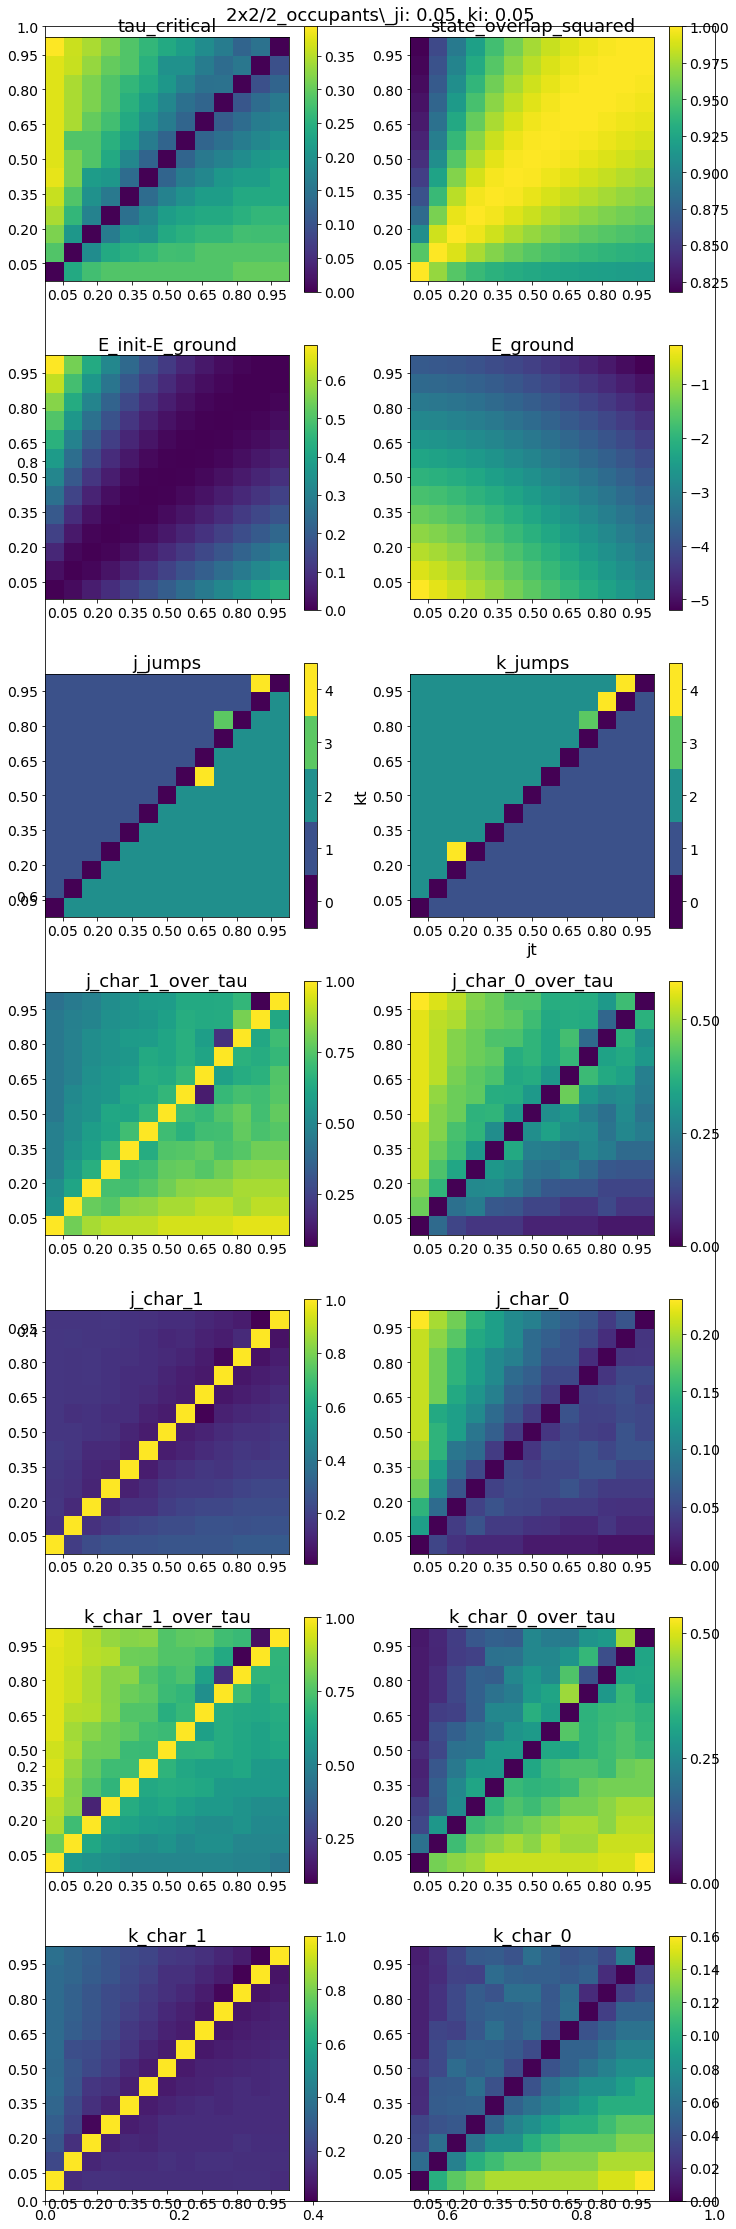

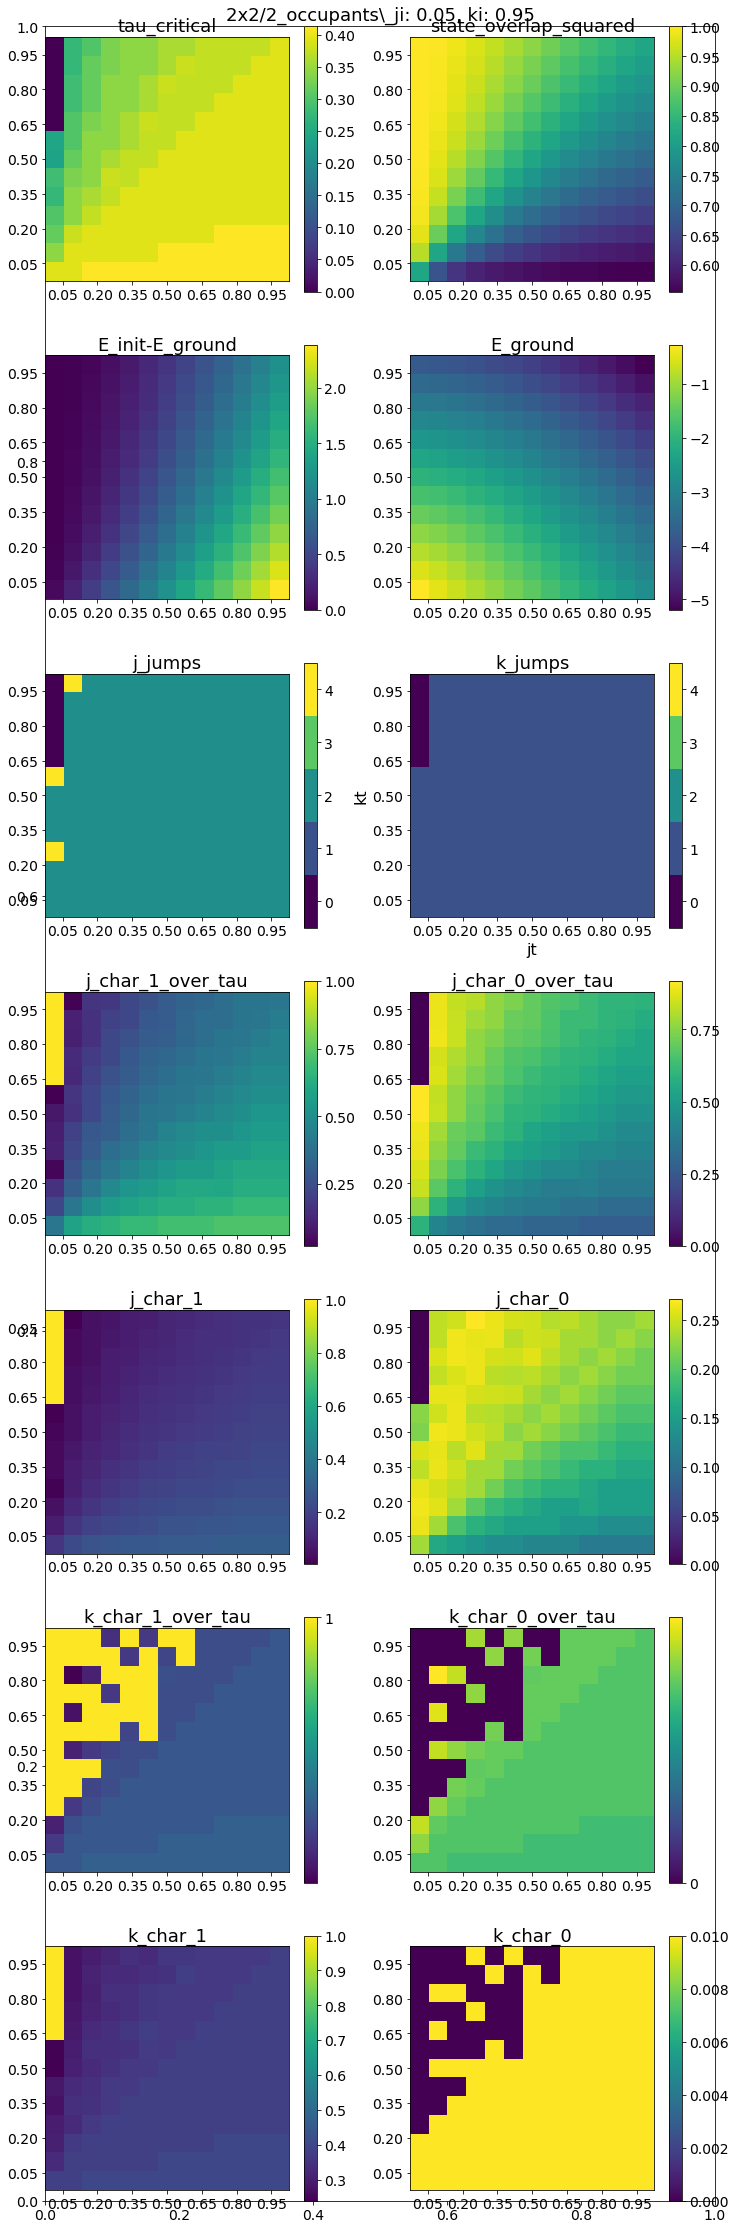

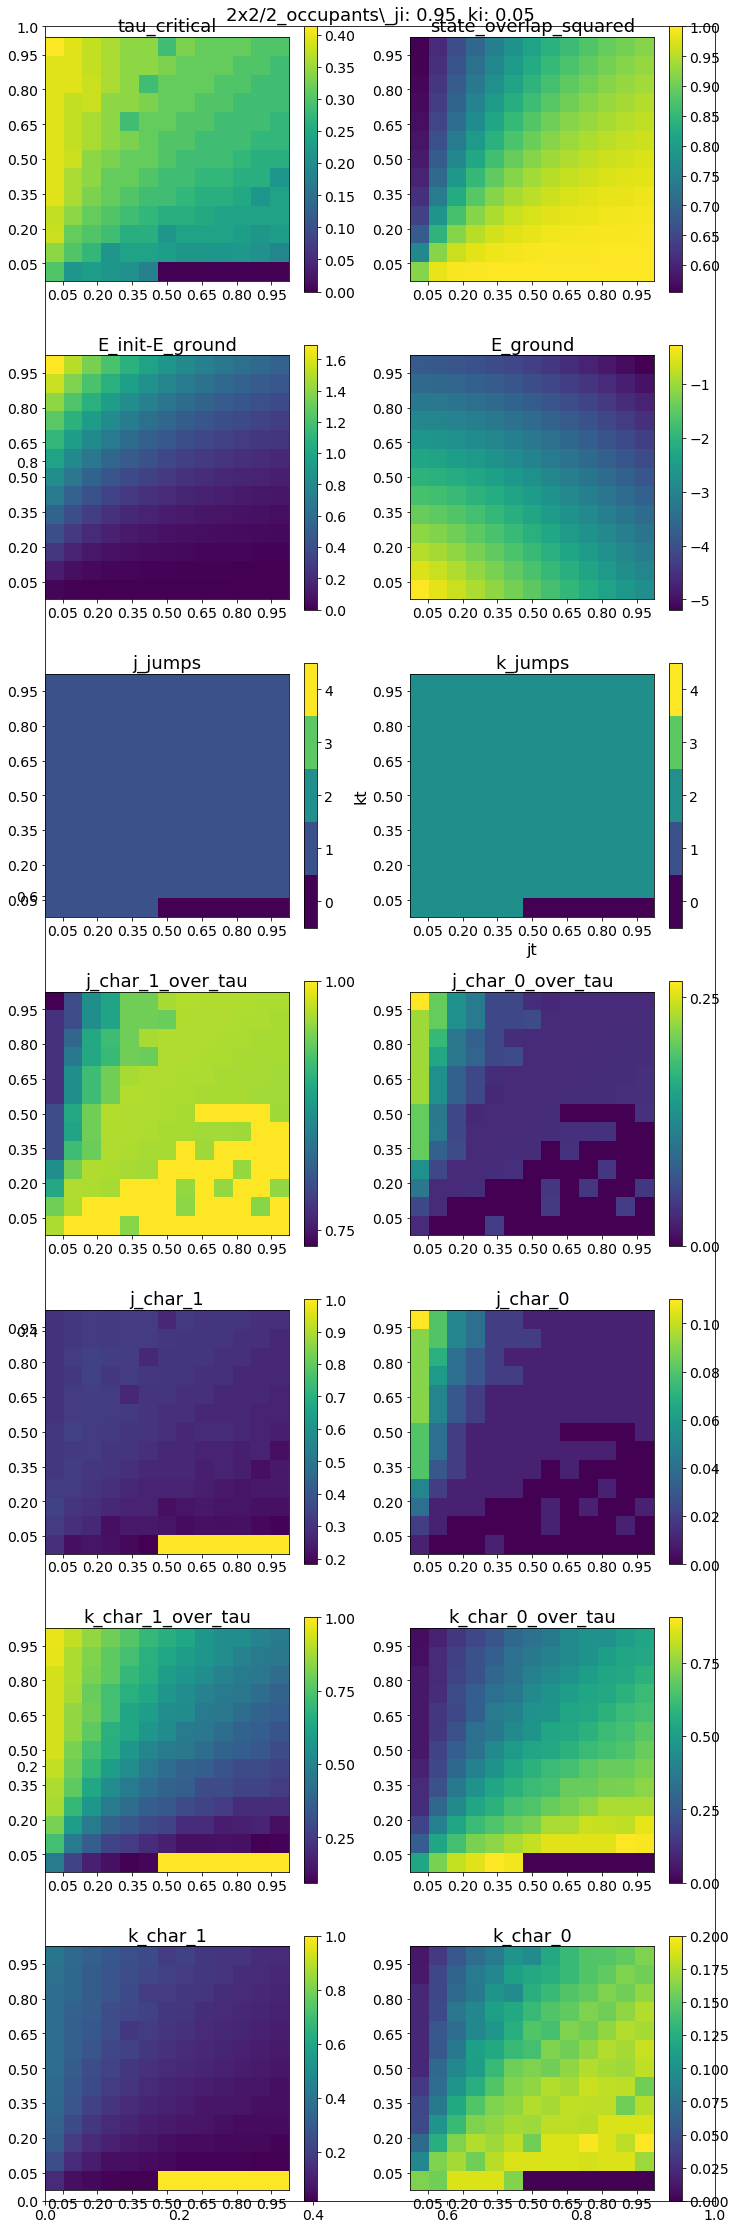

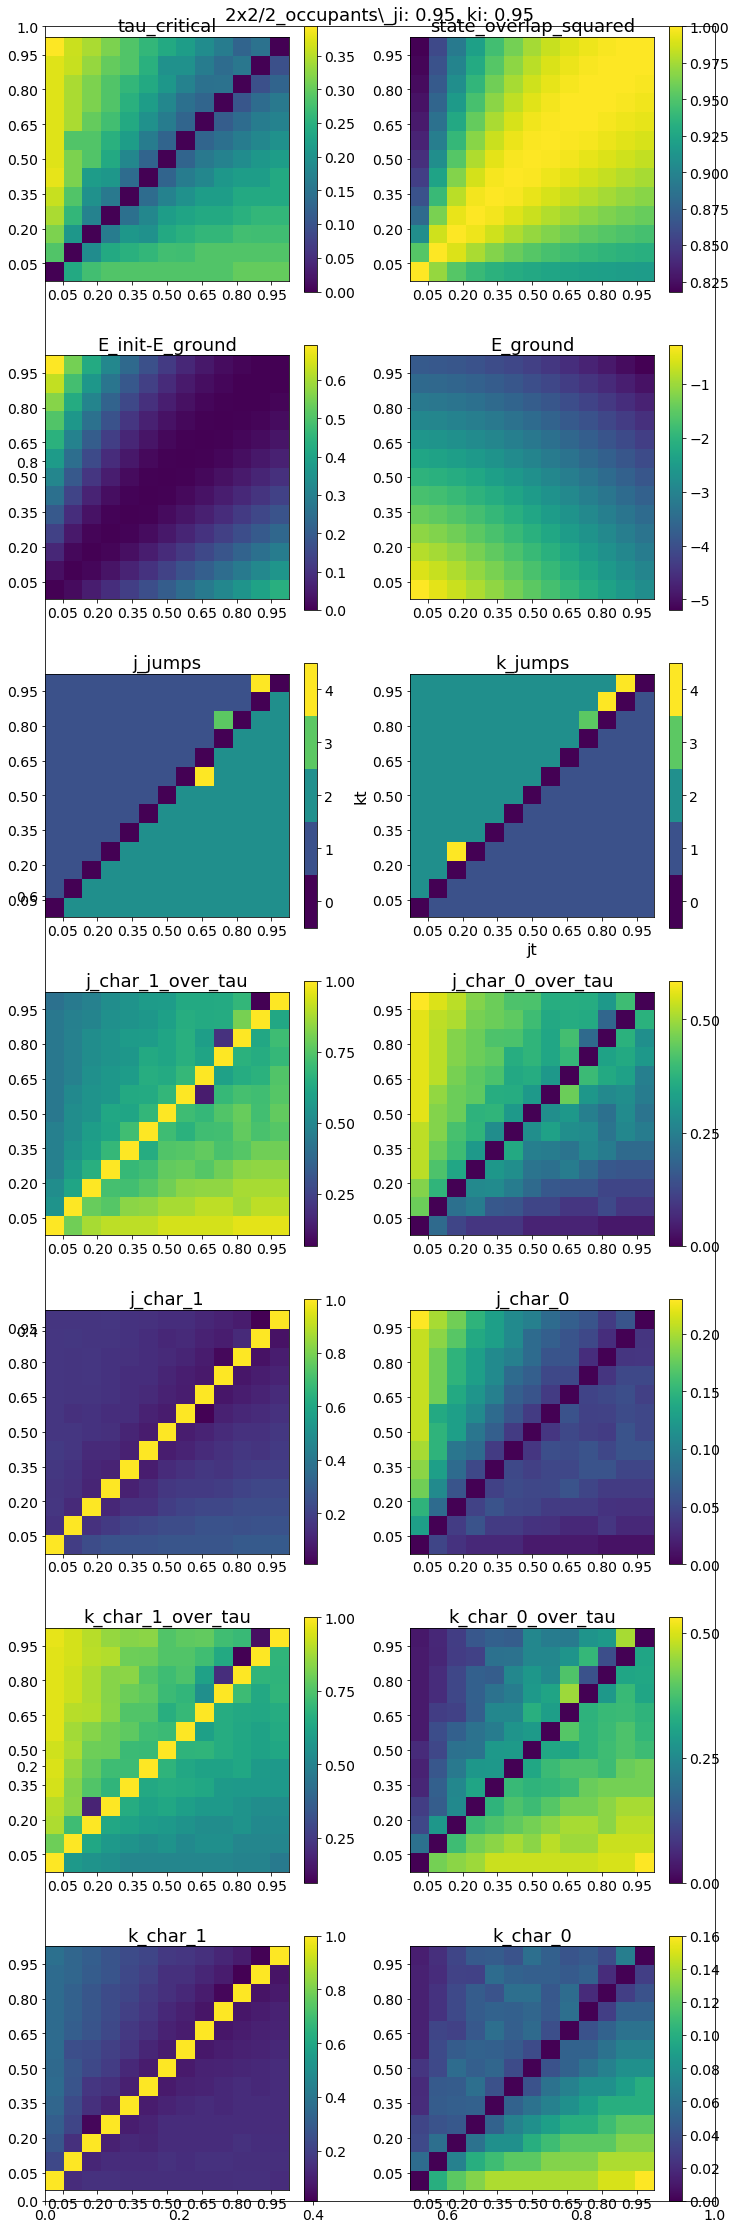

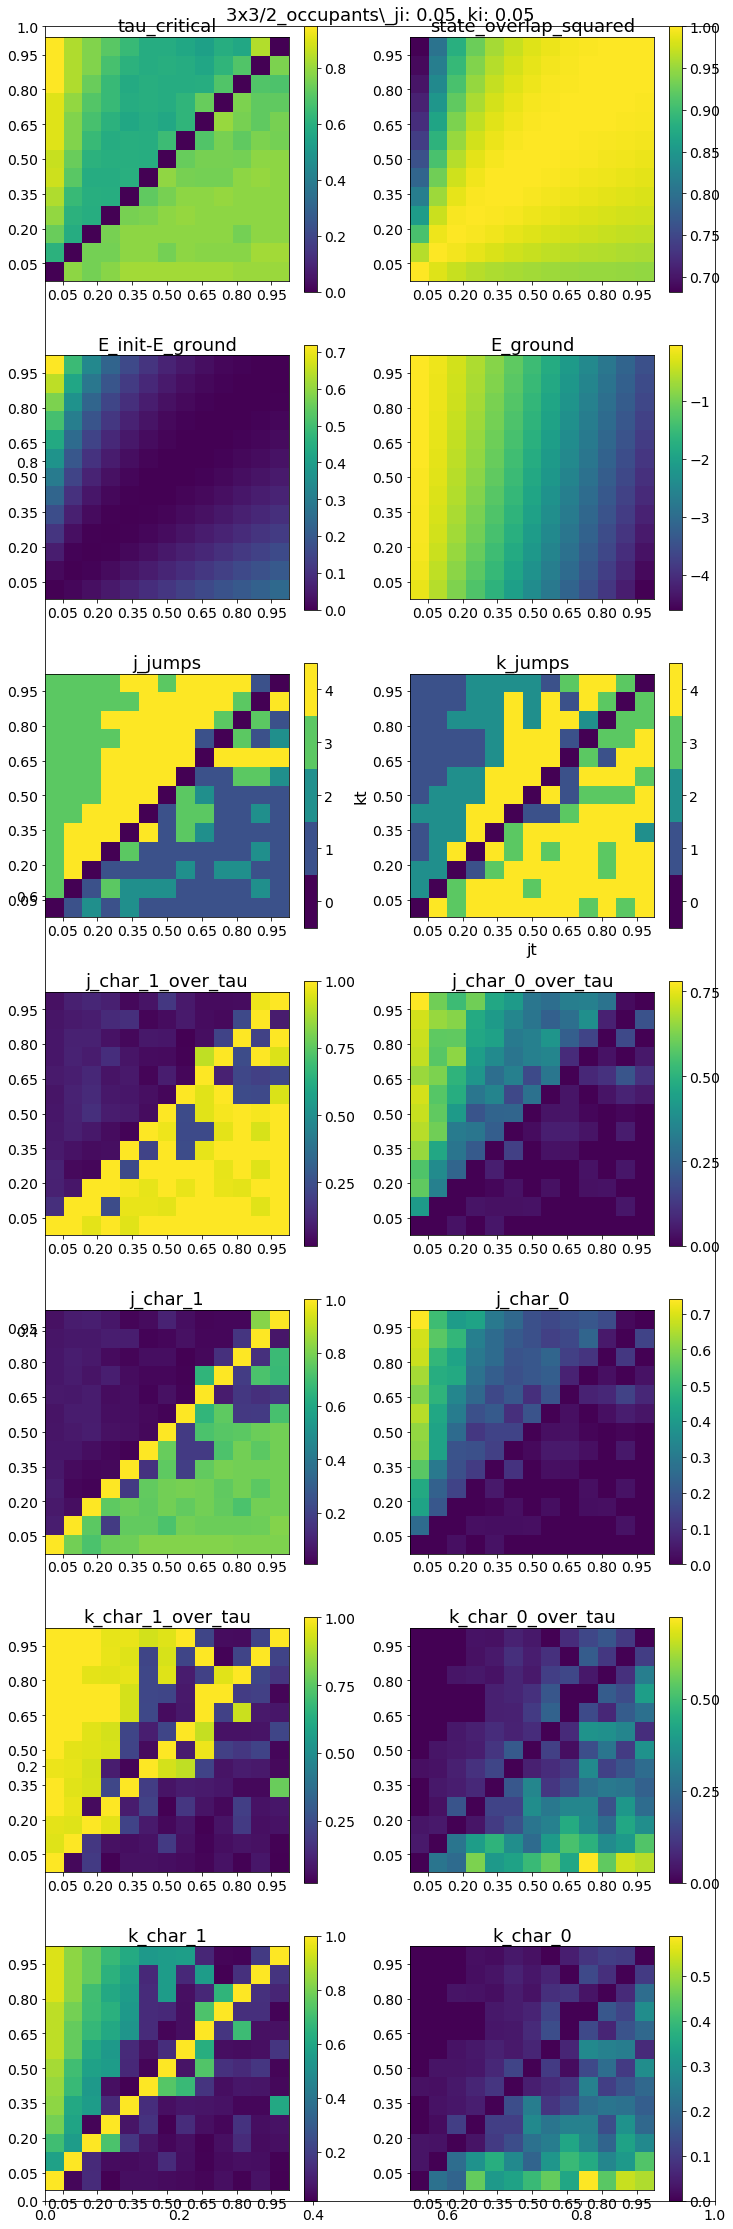

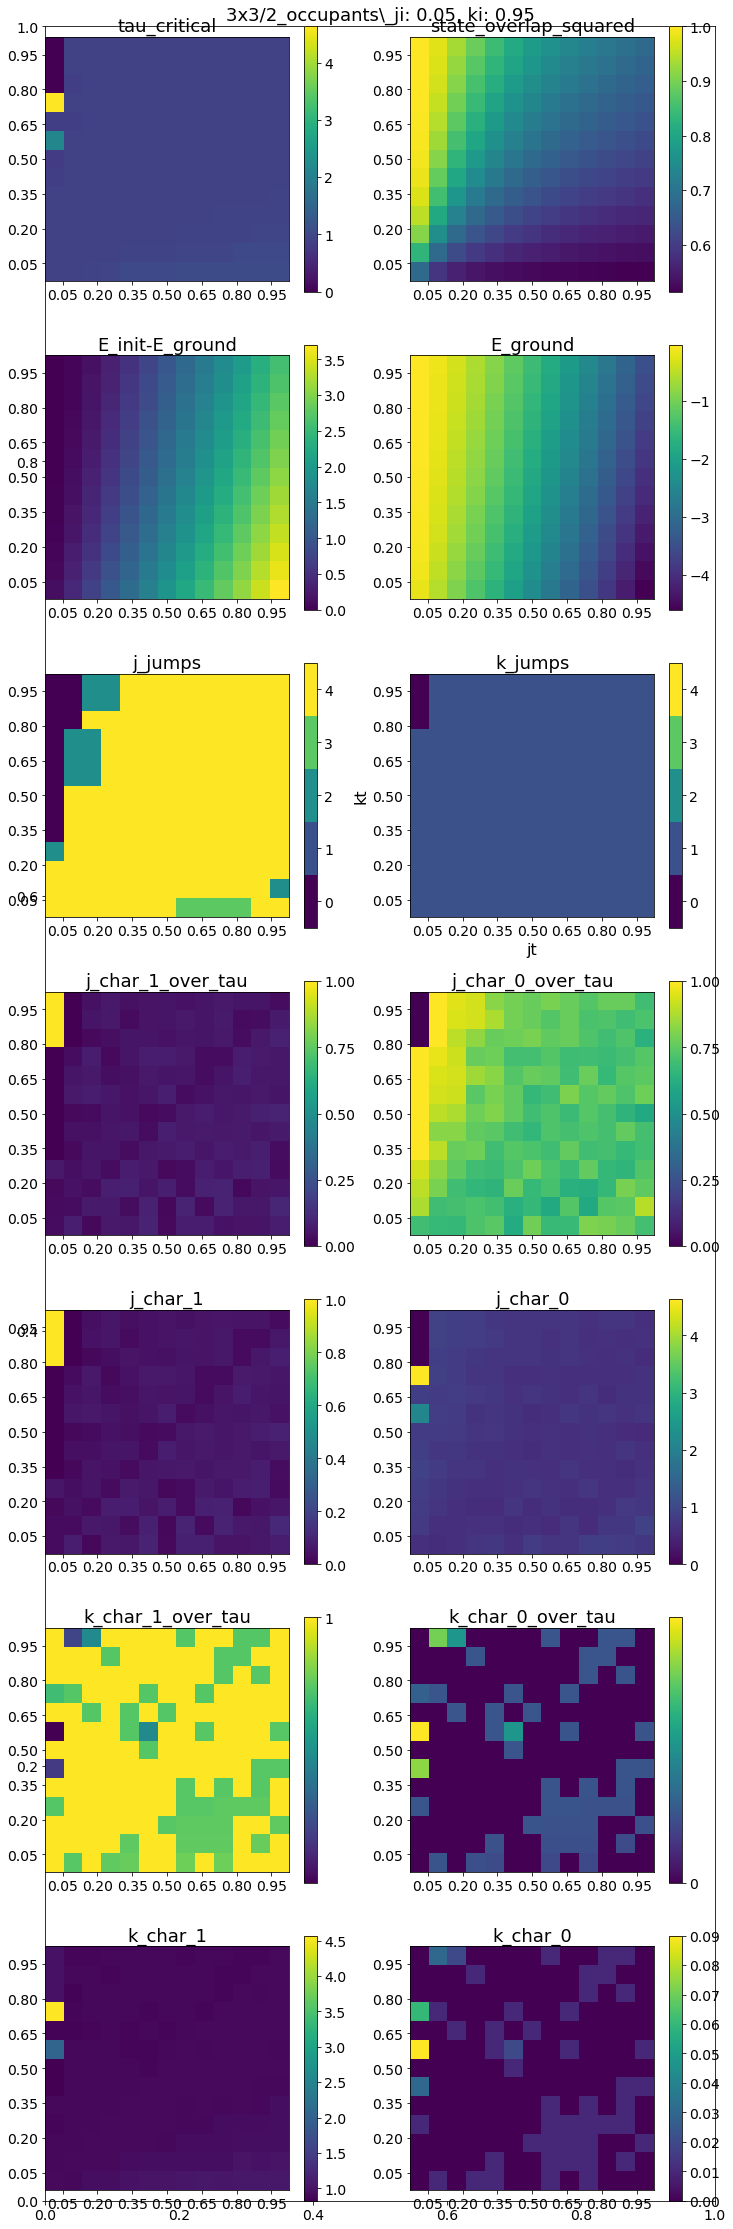

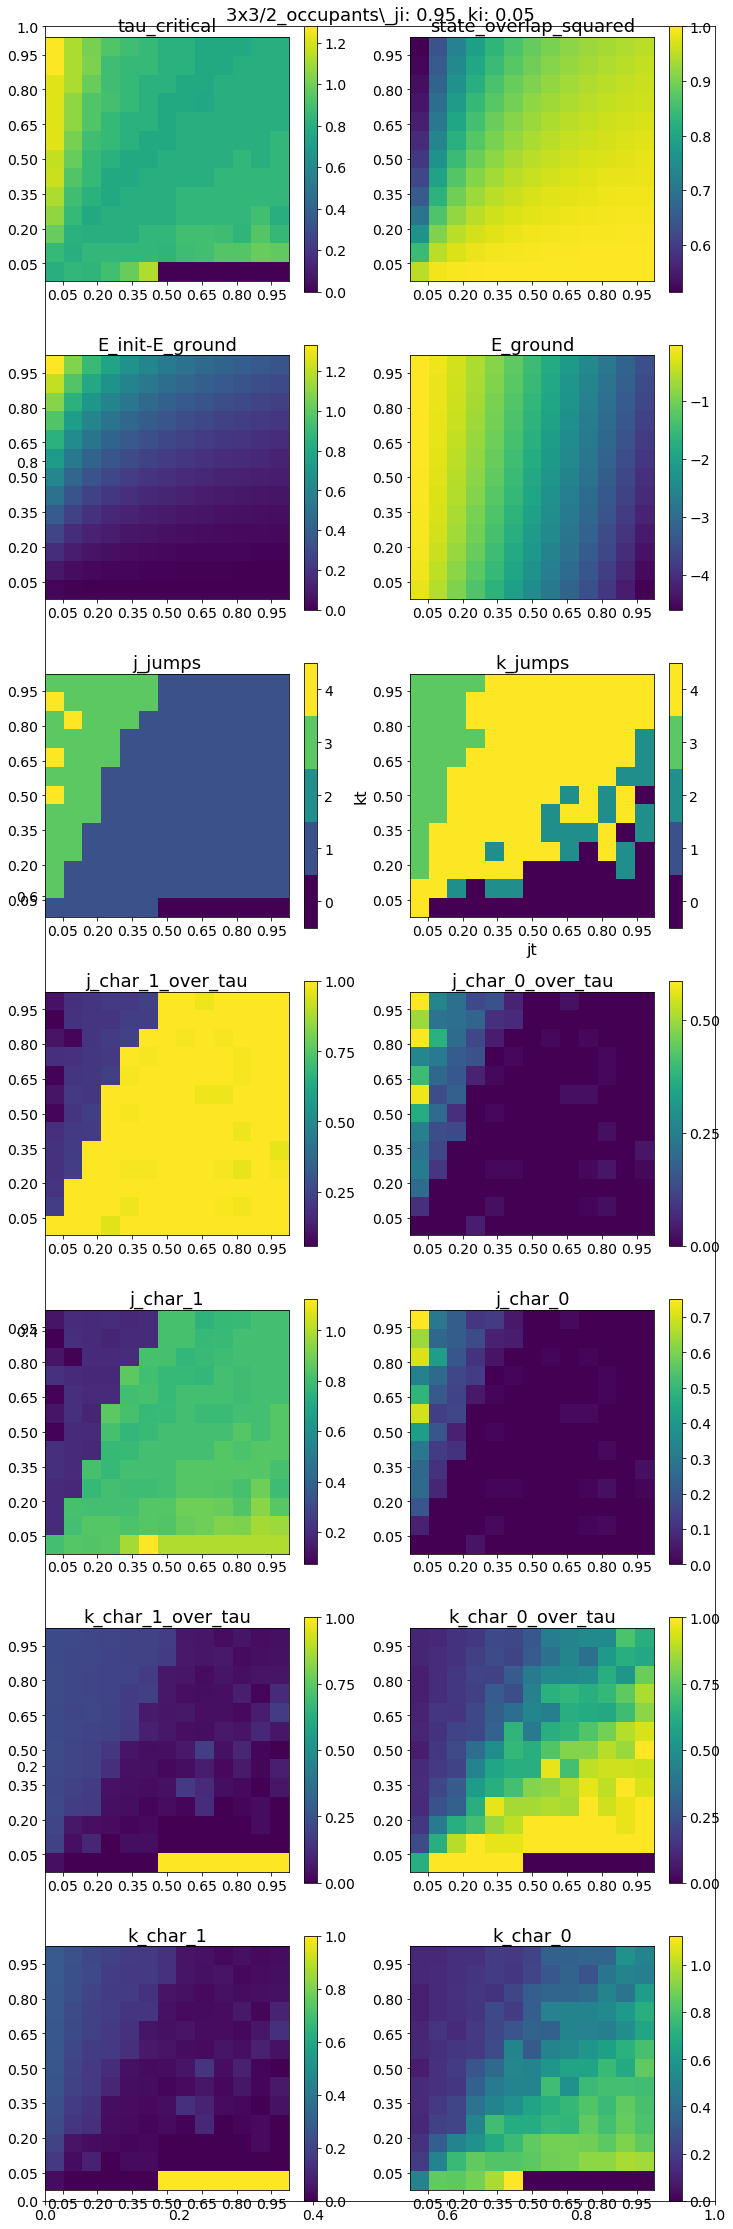

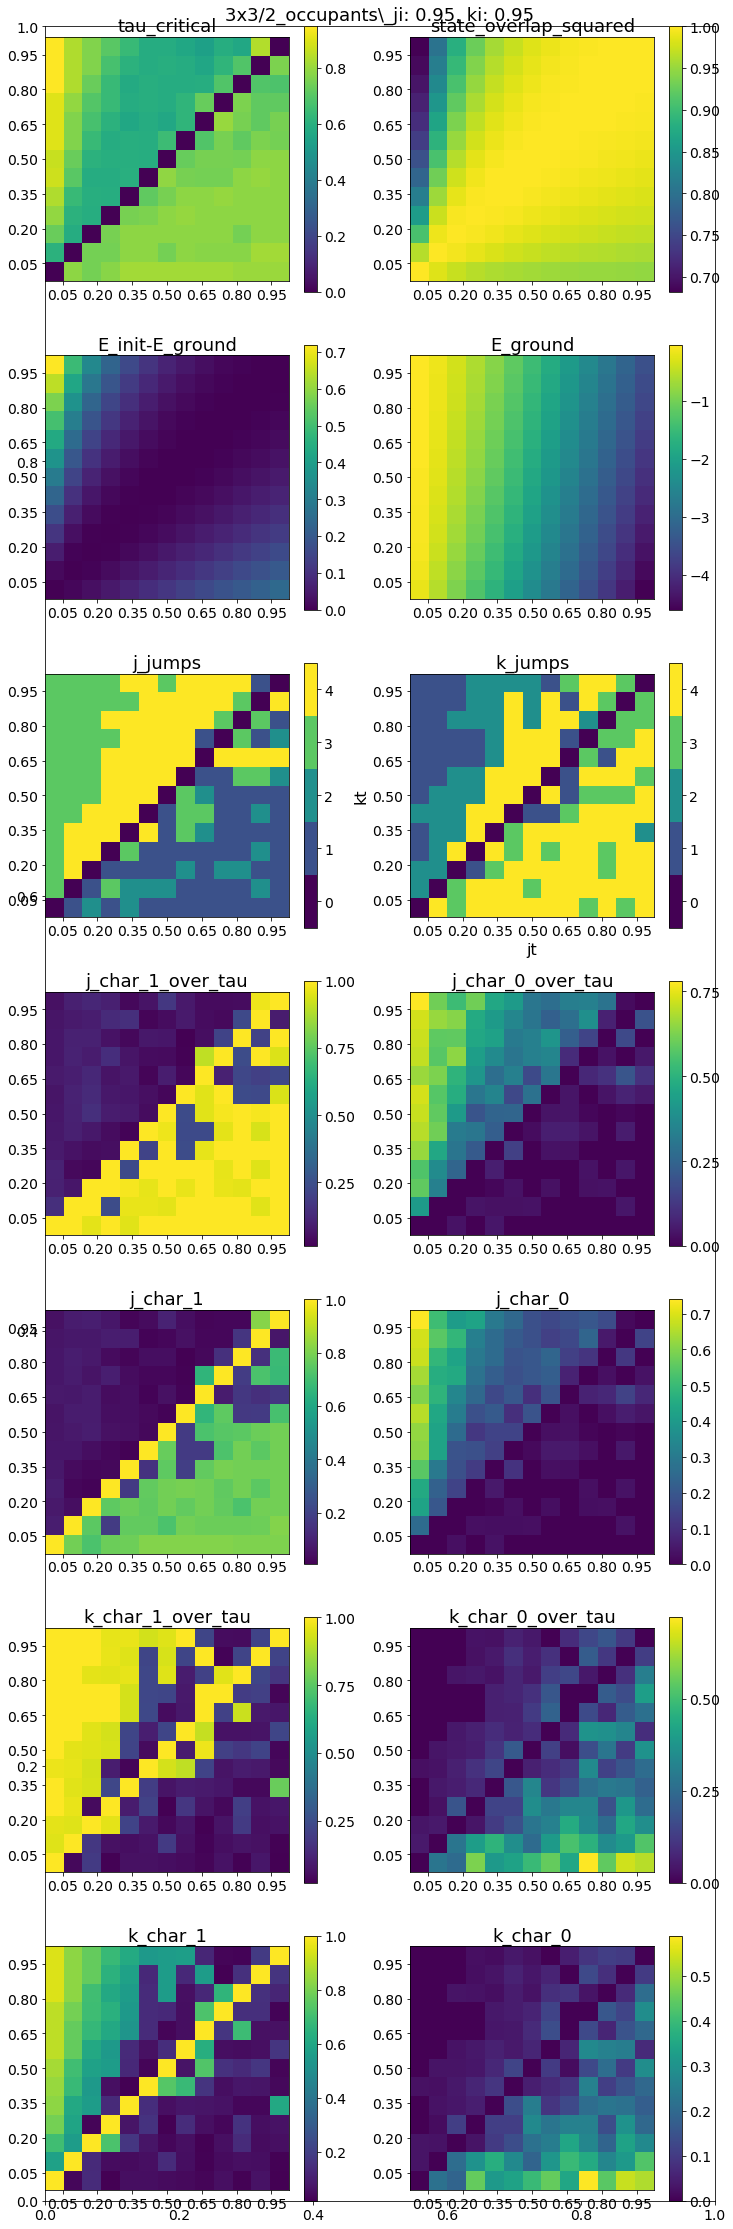

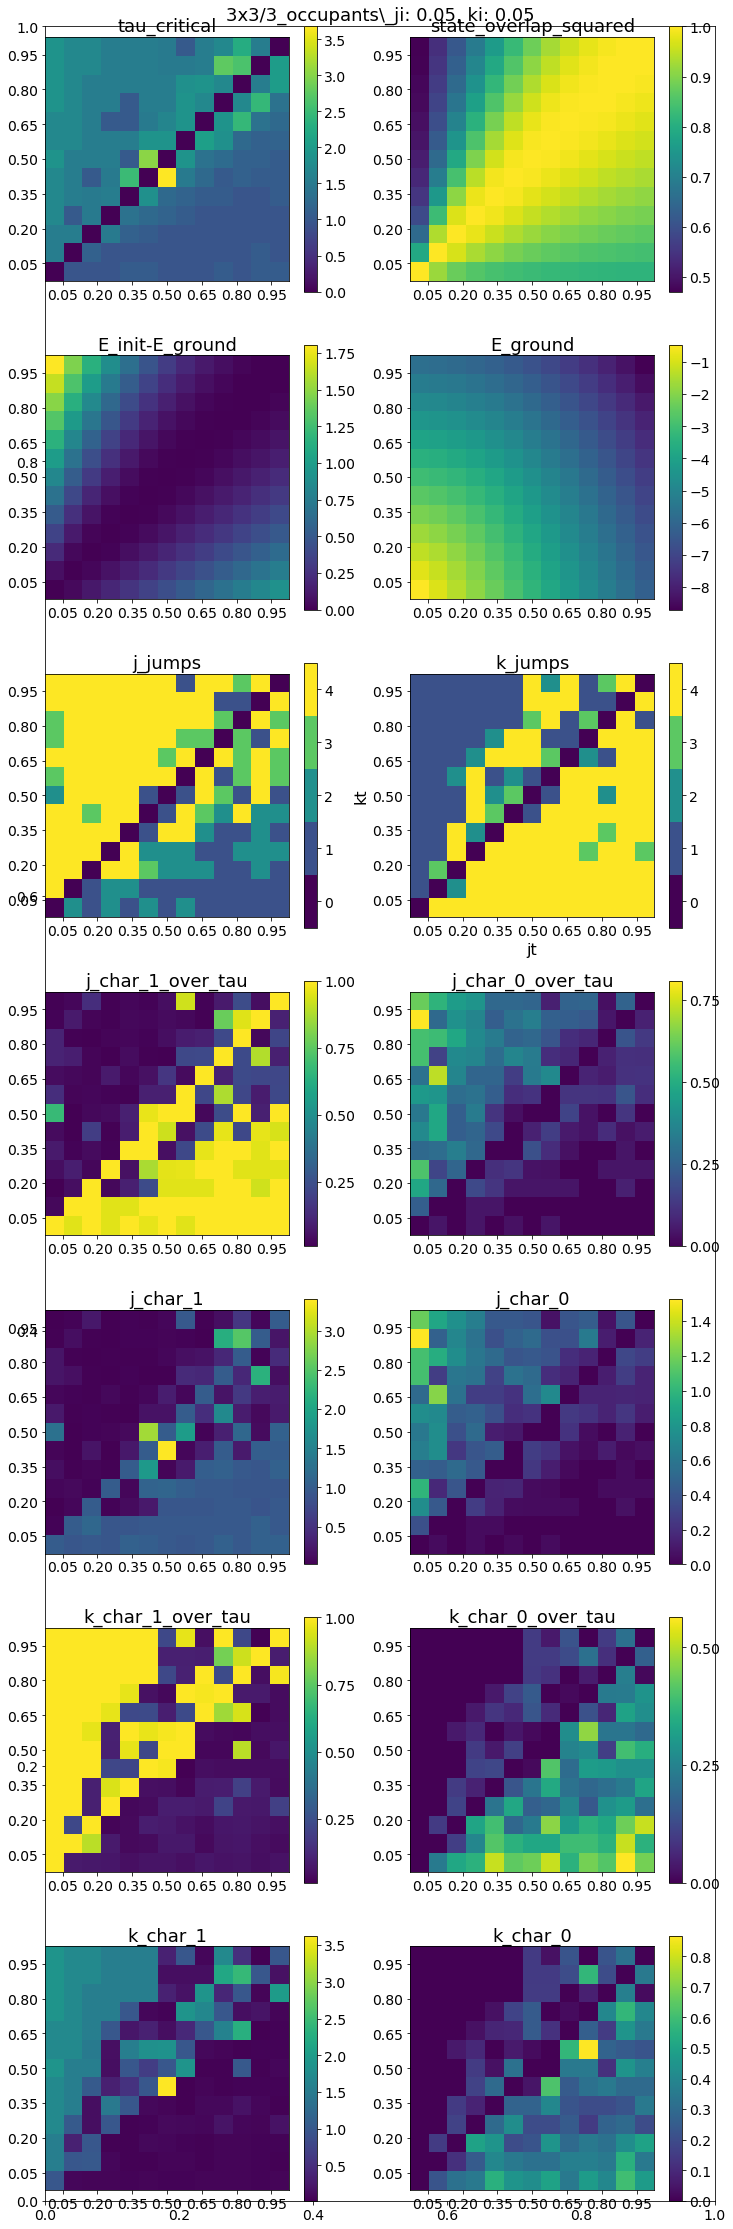

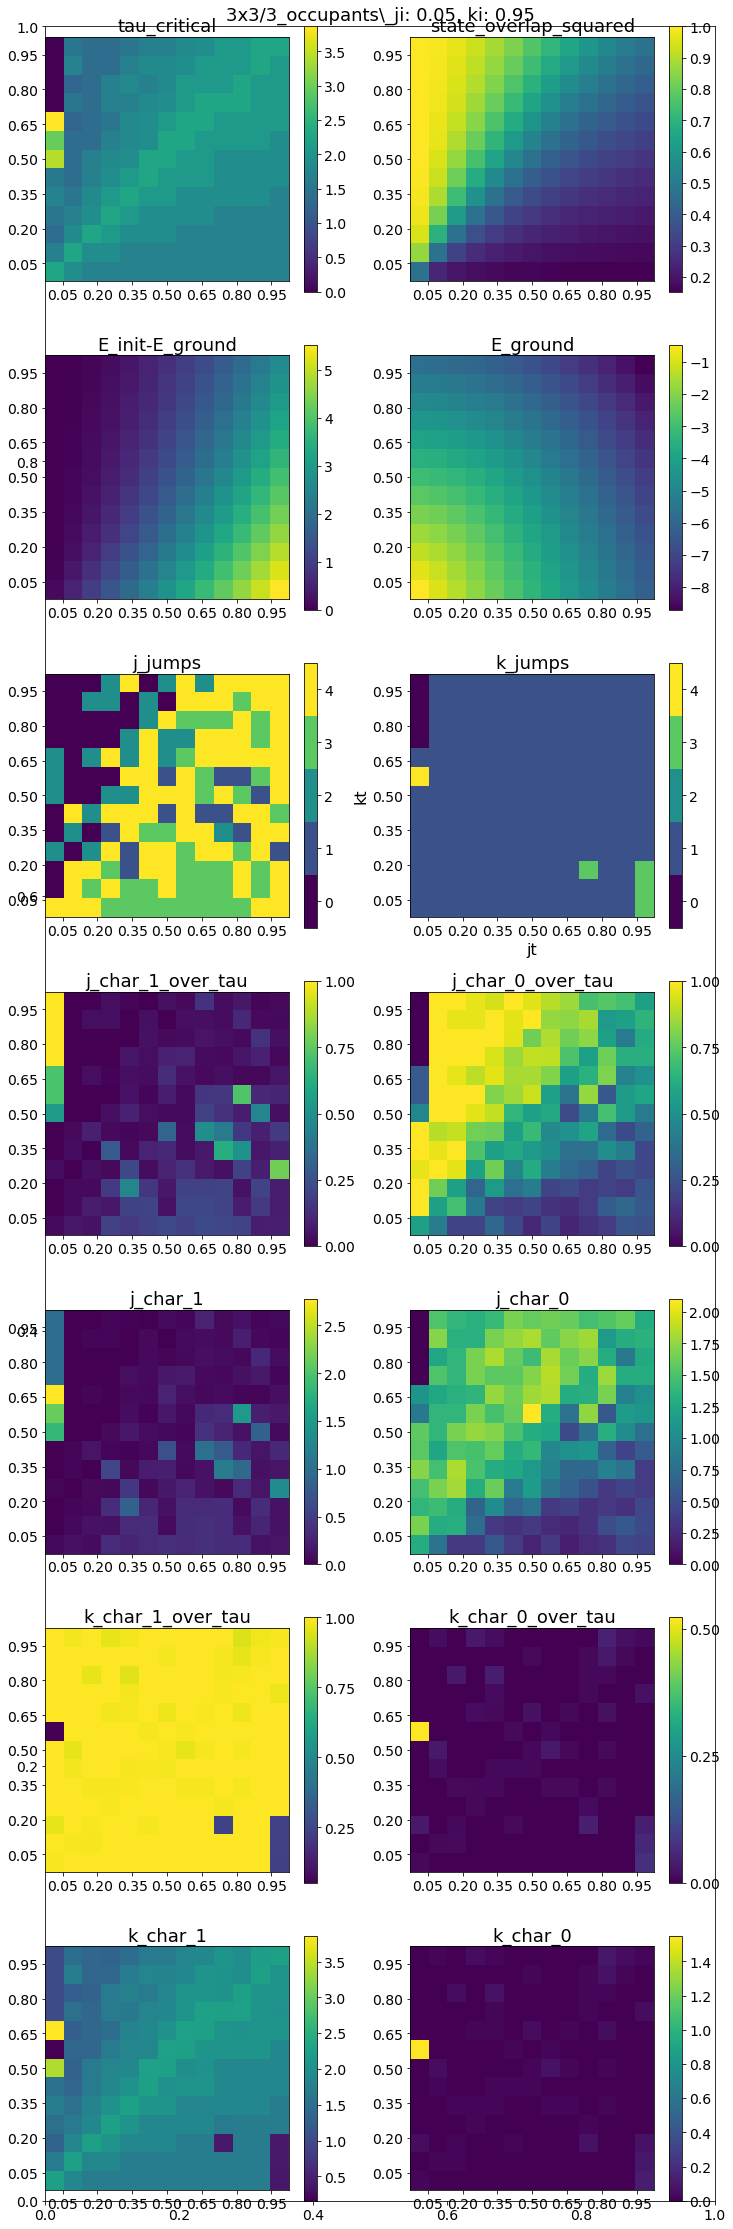

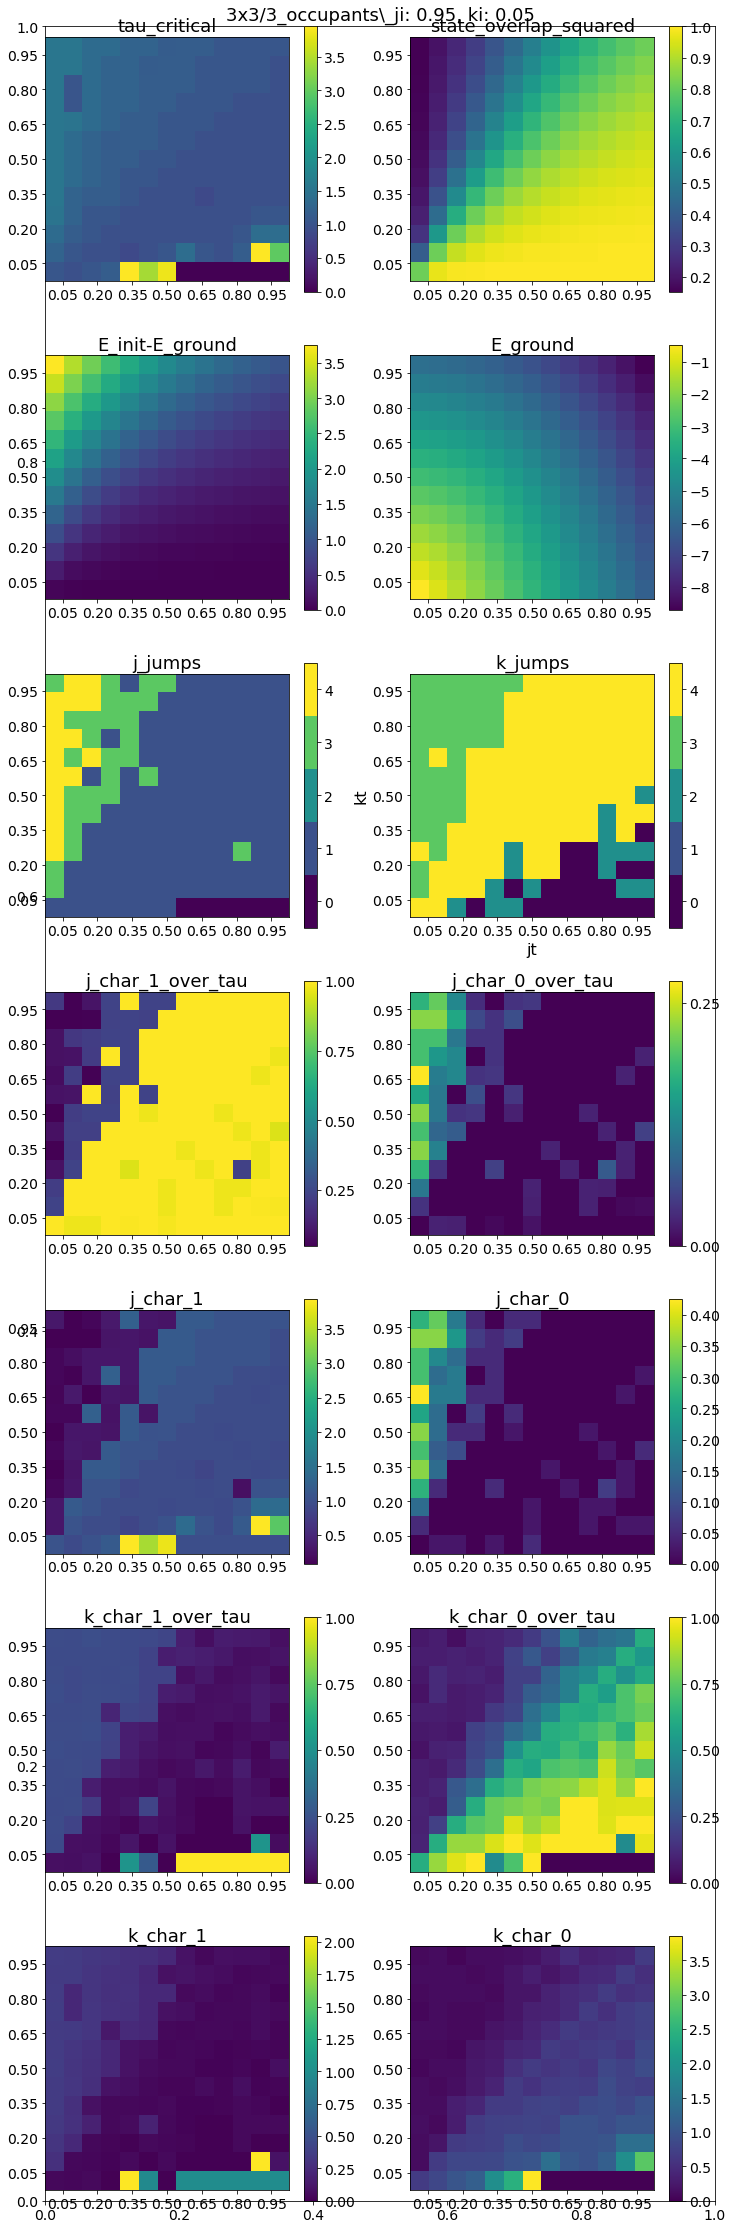

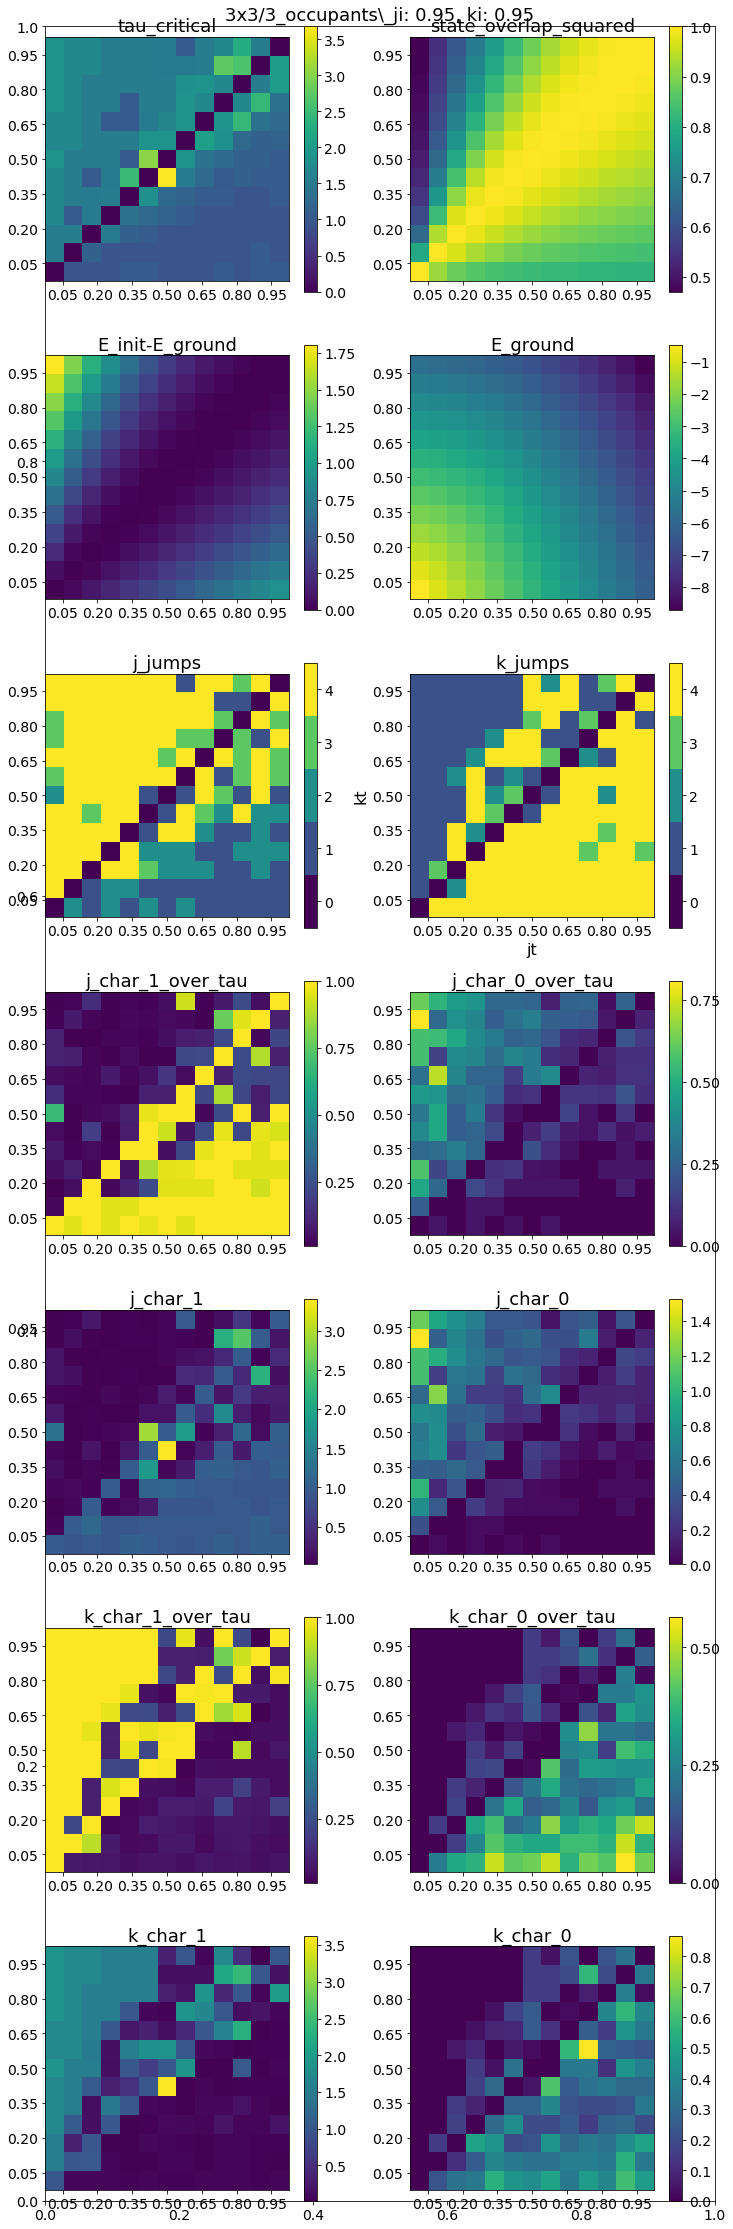

In [129]:
save = False
plot_everything_for_initial(data_mcdb_whole,save, "MCDB")
# plot_data(data_mcbb_whole,data_1mcbf_whole,data_adia_whole, save)

In [65]:
print(data_mcdb_whole[1][47])
print()
print(get_values(data_mcdb_whole[1][47], "parameters"))
print(get_values(data_mcdb_whole[1][47], "distance_array"))


[['parameters', 'j_protocols', 'k_protocols', 'b_protocols', 'tau_array', 'best_E_array', 'distance_array', 'total_steps_array', 'time_step_array'], [[['NUM_SEEDS', 'DISTANCE_LIMIT_MCDB', 'TAU_INIT_MCDB', 'MAX_TAU_MCDB', 'TAU_SCALAR_MCDB', 'TAU_SCALAR_MCDB_TINY', 'TAU_SCALAR_MCDB_BIG', 'ACCEPTANCE_PROB_MCDB', 'TEMP_EXP_DECAY_MCDB', 'BINARY_SEARCH_TAU_LIMIT_MCDB', 'RANDOM_STATES_MCDB', 'TIME_STEP_MCDB', 'SWEEPS_MCDB', 'TEMP_DECAY_ITERATIONS_MCDB', 'TEMP_DECAY_LIMIT_MCDB', 'MAX_TAU_STEPS_MCDB', 'MAX_BS_STEPS_MCDB', 'GROUND_E', 'INITIAL_E', 'j_initial', 'k_initial', 'b_initial', 'j_target', 'k_target', 'b_target', 'state_overlap_squared', 'PERIODIC', 'UNIFORM_SITES', 'DEVICE_DIMENSION', 'MAX_PARAM', 'MIN_PARAM'], ['4', '0.02', '0.05', '1', '1.1', '1.05', '1.2', '0.8', '0.8', '0.0005', '3', '0.01', '70', '20', '7', '32', '8', '-2.81493', '-2.68564', '0.05', '0.05', '0', '0.275', '0.65', '0', '0.95733', 'false', 'true', '2', '1', '0']], [], [], [], [], [], [], [5, 6, 7, 8, 10, 12, 14, 17, 1

# Label Reminders

In [89]:
'''
data_mcbb_whole[0][n] = name of nth file
data_mcbb_whole[1][n] = data for the nth file


letting data = data_mcbb_whole[1][n], the data for the nth file, get_values(data, 'NAME') will return
the values associated with NAME for the nth file. The possible inputs for NAME are printed below:

['parameters', 'j_protocols', 'k_protocols', 'b_protocols', 'tau_array', 'best_E_array', 
'distance_array', 'j_protocols_reduced', 'k_protocols_reduced', 'b_protocols_reduced', 
'j_jumps', 'k_jumps', 'b_jumps', 'j_char_time', 'j_char_time_over_tau', 'k_char_time', 
'k_char_time_over_tau', 'b_char_time', 'b_char_time_over_tau']
'''

print(data_mcbb_whole[1][0][0])
print()
print(data_mcbb_whole[1][0][1])
print()
print(get_values(data_mcbb_whole[1][0], "parameters"))
print()
print(get_values(get_values(data_mcbb_whole[1][0], "parameters"), 'GROUND_E'))

['parameters', 'j_protocols', 'k_protocols', 'b_protocols', 'tau_array', 'best_E_array', 'distance_array', 'j_protocols_reduced', 'k_protocols_reduced', 'b_protocols_reduced', 'j_jumps', 'k_jumps', 'b_jumps', 'j_char_time', 'j_char_time_over_tau', 'k_char_time', 'k_char_time_over_tau', 'b_char_time', 'b_char_time_over_tau']

[[['DIAG', 'NUM_SEEDS', 'DISTANCE_LIMIT_MCBB', 'TAU_INIT_MCBB', 'MAX_TAU_MCBB', 'TAU_SCALAR_MCBB', 'TAU_SCALAR_MCBB_TINY', 'TAU_SCALAR_MCBB_BIG', 'MAX_CHANGE_FRACTION_MCBB', 'MIN_CHANGE_FRACTION_MCBB', 'ACCEPTANCE_PROB_MCBB', 'TEMP_EXP_DECAY_MCBB', 'BINARY_SEARCH_TAU_LIMIT_MCBB', 'RANDOM_STATES_MCBB', 'NUMBER_OF_BANGS', 'SWEEPS_MCBB', 'TEMP_DECAY_ITERATIONS_MCBB', 'TEMP_DECAY_LIMIT_MCBB', 'MAX_TAU_STEPS_MCBB', 'MAX_BS_STEPS_MCDB', 'GROUND_E', 'INITIAL_E', 'j_initial', 'k_initial', 'b_initial', 'j_target', 'k_target', 'b_target', 'state_overlap_squared', 'PERIODIC', 'UNIFORM_SITES', 'DEVICE_DIMENSION', 'MAX_PARAM', 'MIN_PARAM'], ['false', '4', '0.02', '0.05', '0.8',

In [10]:
'''
data_mcdb_whole[0][n] = name of nth file
data_mcdb_whole[1][n] = data for the nth file


letting data = data_mcdb_whole[1][n], the data for the nth file, get_values(data, 'NAME') will return
the values associated with NAME for the nth file. The possible inputs for NAME are printed below:

['parameters', 'j_protocols', 'k_protocols', 'b_protocols', 'tau_array', 'best_E_array', 
'distance_array', 'j_protocols_reduced', 'k_protocols_reduced', 'b_protocols_reduced', 
'j_jumps', 'k_jumps', 'b_jumps', 'j_char_time', 'j_char_time_over_tau', 'k_char_time', 
'k_char_time_over_tau', 'b_char_time', 'b_char_time_over_tau']
'''

print(data_mcdb_whole[1][0][0])
print()
print(data_mcdb_whole[1][0][1])
print()
print(get_values(data_mcdb_whole[1][0], "parameters"))
print()
print(get_values(get_values(data_mcdb_whole[1][0], "parameters"), 'GROUND_E'))

['parameters', 'j_protocols', 'k_protocols', 'b_protocols', 'tau_array', 'best_E_array', 'distance_array', 'total_steps_array', 'time_step_array']

[[['NUM_SEEDS', 'DISTANCE_LIMIT_MCDB', 'TAU_INIT_MCDB', 'MAX_TAU_MCDB', 'TAU_SCALAR_MCDB', 'TAU_SCALAR_MCDB_TINY', 'TAU_SCALAR_MCDB_BIG', 'ACCEPTANCE_PROB_MCDB', 'TEMP_EXP_DECAY_MCDB', 'BINARY_SEARCH_TAU_LIMIT_MCDB', 'RANDOM_STATES_MCDB', 'TIME_STEP_MCDB', 'SWEEPS_MCDB', 'TEMP_DECAY_ITERATIONS_MCDB', 'TEMP_DECAY_LIMIT_MCDB', 'MAX_TAU_STEPS_MCDB', 'MAX_BS_STEPS_MCDB', 'GROUND_E', 'INITIAL_E', 'j_initial', 'k_initial', 'b_initial', 'j_target', 'k_target', 'b_target', 'state_overlap_squared', 'PERIODIC', 'UNIFORM_SITES', 'DEVICE_DIMENSION', 'MAX_PARAM', 'MIN_PARAM'], ['4', '0.02', '0.05', '1', '1.1', '1.05', '1.2', '0.8', '0.8', '0.0005', '3', '0.01', '70', '20', '7', '32', '8', '-0.273205', '-0.273205', '0.05', '0.05', '0', '0.05', '0.05', '0', '1', 'false', 'true', '2', '1', '0']], [[0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0]], [0.

# GRAVEYARD

# Appending the state overlap

In [24]:
# with open("../data/overlap.txt", 'r') as file:
#     data = file.readlines()
#     for line in data:
#         line = line.rstrip('\n').split(" ")
#         num = line[0]
#         ji = line[1]
#         ki = line[2]
#         jt = line[3]
#         kt = line[4]
#         state_overlap = line[5]
#         path = "../data/3x3/"+num+"_occupants/MCBB___PBC=t_UNI=t_DD=2___ji="+ji+"_ki="+ki+"_jt="+jt+"_kt="+kt#+".txt"
#         conditions = [num]
#         for filepath in glob.iglob("../data/3x3/"+num+"_occupants/" + '*.txt'):
#             conditions = [num+"_occu" in filepath,
#                          "ji="+ji in filepath,
#                          "ki="+ki in filepath,
#                          "jt="+jt in filepath,
#                          "kt="+kt in filepath,]
#             if(all(conditions)):
#                 f=open(filepath, "r")
#                 contents = f.readlines()
#                 f.close()
#                 if("state_overlap" in contents[29]): contents[29]="state_overlap_squared =    "+state_overlap+"\n"
#                 else: contents.insert(29, "state_overlap_squared =    "+state_overlap+"\n")
#                 f = open(filepath, "w")
#                 contents = "".join(contents)
#                 f.write(contents)
#                 f.close()

# Interpolation

In [54]:
#for the interpolation, we want:
#tau, the time of the nearest neighbor jumps, the best energy
#a nice way to save the old data and add on the new jumps
# input the jumps of two neighbors in either direction

def get_data_set(data_mcbb_whole, dir_, ji, ki, jt, kt):
    index = []
    for x in range(len(data_mcbb_whole[0])):
        conditions = ["ji="+str(ji) in data_mcbb_whole[0][x], 
                      "ki="+str(ki) in data_mcbb_whole[0][x],
                      "jt="+str(jt) in data_mcbb_whole[0][x],
                      "kt="+str(kt) in data_mcbb_whole[0][x],
                      dir_ in data_mcbb_whole[0][x]]
        if(all(conditions)): index.append(x)
    if(len(index) != 1):print("\n\nERROR\n\n")
    else: return data_mcbb_whole[1][index[0]]
    
my_dirs = ['../data/3x3/3_occupants']  
interpolation_info = [[0.05, 0.05, [[0.35,0.95], [0.65, 0.95]], "j"],
                     ]
for interp_set in interpolation_info:
    ji = interp_set[0]
    ki = interp_set[1]
    target1 = interp_set[2][0]
    target2 = interp_set[2][1]
    j_or_k = interp_set[3]
    jt1, kt1 = target1[0], target1[1]
    jt2, kt2 = target2[0], target2[1]
    data1 = get_data_set(data_mcbb_whole, my_dirs[0], ji, ki, jt1, kt1)
    data2 = get_data_set(data_mcbb_whole, my_dirs[0], ji, ki, jt2, kt2)
    data_to_change = get_data_set(data_mcbb_whole, my_dirs[0], ji, ki, (jt1+jt2)/2, (kt1+kt2)/2)

    p1 = get_values(data1, "j_protocols_reduced")[-1]
    p2 = get_values(data2, "j_protocols_reduced")[-1]

    if(len(p1) != len(p2)): print("ERROR, Protocols don't have the same number of jumps")
    new_j_jumps = []
    for t1, t2 in zip(p1, p2):
        new_j_jumps.append((t1+t2)/2)
        
    p1 = get_values(data1, "k_protocols_reduced")[-1]
    p2 = get_values(data2, "k_protocols_reduced")[-1]

    if(len(p1) != len(p2)): print("ERROR, Protocols don't have the same number of jumps")
    new_k_jumps = []
    for t1, t2 in zip(p1, p2):
        new_k_jumps.append((t1+t2)/2)
        
    print("\nji="+str(ji)+" ki="+str(ki)+" jt="+str((jt1+jt2)/2)+" kt="+str((kt1+kt2)/2))
    print("tau="+str(get_values(data_to_change, "tau_array")[-1])+"  best_E="+str(get_values(data_to_change, "best_E_array")[-1]))
#     print("Old j=")
#     print(get_values(data_to_change, "j_protocols_reduced")[-1])
#     print("Old k=")
#     print(get_values(data_to_change, "k_protocols_reduced")[-1])
    print("new Tau = " + str((get_values(data1, "tau_array")[-1]+get_values(data2, "tau_array")[-1])/2))
    print("New j=")
    print(new_j_jumps)
    print("New k=")
    print(new_k_jumps)


ji=0.05 ki=0.05 jt=0.5 kt=0.95
tau=0.532091  best_E=-7.46092
new Tau = 0.5059985
New j=
[0.053341200000000005, 0.207361, 0.2827445, 0.42718500000000004]
New k=
[0.00540225, 0.437875]


#  Gap Plot

In [ ]:
def plot_gap():
    filepath = '../data/gap.txt'
    j, k, gap = [],[],[]
    
    for line in open(filepath, "rt"):     
        line = line.rstrip("\n")
        if line.startswith('gap'): gap.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('j'):   j.append(literal_eval((line.split('=')[-1]).replace(" ", "")))
        elif line.startswith('k'):   k.append(literal_eval((line.split('=')[-1]).replace(" ", "")))

    plt.figure()
    plt.ylabel("k")
    plt.xlabel("j")
    plt.ylim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.scatter(j, k, c=gap, cmap = cmap, s = 10, alpha=0.7)
    cbar = plt.colorbar(label = 'gap')
    #plt.scatter(0.1, 0.1, s = 100, c = 'pink', label = 'initial')
    #plt.scatter(1, 1, s = 100, c = 'black', label = 'target')
    #plt.legend()
    plt.savefig("../data/gap_plot_3x3_4_occ.pdf")
    plt.show()

plot_gap()

# Creating the Directory Structure

In [3]:
max_lattice_size = 6
'''Rectangular Lattice
for n in range(2,max_lattice_size+1):
    for m in range(2,max_lattice_size+1):
        for x in  range(2, m*n-1):
            if(m>=n): #preventing creation of both mxn and nxm
                dir = '../data/'+str(n)+'x'+str(m)+'/'+str(x)+'_occupants'
                if not os.path.exists(dir):
                    os.makedirs(dir)
'''
#Square Lattice
for n in range(2,max_lattice_size+1):
    for x in  range(2, n*n-1):
        dir = '../data/'+str(n)+'x'+str(n)+'/'+str(x)+'_occupants'
        if not os.path.exists(dir):
            os.makedirs(dir)            